# K√ºt√ºphaneleri & Data Setini y√ºkleme

In [ ]:
!pip install catboost

In [ ]:
# Temel k√ºt√ºphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Uyarƒ±larƒ± kapatma
import warnings
warnings.filterwarnings("ignore")

# Veri √∂n i≈üleme
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Modeller
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Deƒüerlendirme metrikleri
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)


In [ ]:
# Renk Paletleri
paired_palette = sns.color_palette("Paired")
paired_colors = sns.color_palette("Paired", n_colors=12)

In [ ]:
df_train = pd.read_csv("heart_disease_uci.csv")

df= df_train.copy()

# **1. Problem Tanƒ±mƒ±**



Bu projede, **Heart Disease UCI** veri seti kullanƒ±larak bireylerin kalp hastalƒ±ƒüƒ± riski olup olmadƒ±ƒüƒ±nƒ± tahmin etmeye y√∂nelik bir sƒ±nƒ±flandƒ±rma modeli geli≈ütirilmi≈ütir.

**Ama√ß:**

Verilen hasta bilgilerine dayanarak `num` deƒüi≈ükeninin (kalp hastalƒ±ƒüƒ± riski) 0 (yok) veya 1 (var) ≈üeklinde sƒ±nƒ±flandƒ±rƒ±lmasƒ±dƒ±r.

**Problem Tipi:**

* **Sƒ±nƒ±flandƒ±rma (Classification)** problemi

**Hedef Deƒüi≈üken:**

* `num`: Kalp hastalƒ±ƒüƒ± riski (0 = yok, 1 = var)


# **2. Veri Analizi ve G√∂rselle≈ütirme (EDA)**


## Veriye Genel Bakƒ±≈ü

In [ ]:
#ilk 5 satƒ±rƒ± g√∂ster
df.head().T

0               1                  2            3  \
id                     1               2                  3            4   
age                   63              67                 67           37   
sex                 Male            Male               Male         Male   
dataset        Cleveland       Cleveland          Cleveland    Cleveland   
cp        typical angina    asymptomatic       asymptomatic  non-anginal   
trestbps           145.0           160.0              120.0        130.0   
chol               233.0           286.0              229.0        250.0   
fbs                 True           False              False        False   
restecg   lv hypertrophy  lv hypertrophy     lv hypertrophy       normal   
thalch             150.0           108.0              129.0        187.0   
exang              False            True               True        False   
oldpeak              2.3             1.5                2.6          3.5   
slope        downsloping            flat               flat  downsloping   
ca                   0.0             3.0                2.0          0.0   
thal        fixed defect          normal  reversable defect       normal   
num                    0               2                  1            0   

                        4  
id                      5  
age                    41  
sex                Female  
dataset         Cleveland  
cp        atypical angina  
trestbps            130.0  
chol                204.0  
fbs                 False  
restecg    lv hypertrophy  
thalch              172.0  
exang               False  
oldpeak               1.4  
slope           upsloping  
ca                    0.0  
thal               normal  
num                     0

In [ ]:
#son 5 satƒ±rƒ± g√∂ster
df.tail().T

915               916               917  \
id                     916               917               918   
age                     54                62                55   
sex                 Female              Male              Male   
dataset      VA Long Beach     VA Long Beach     VA Long Beach   
cp            asymptomatic    typical angina      asymptomatic   
trestbps             127.0               NaN             122.0   
chol                 333.0             139.0             223.0   
fbs                   True             False              True   
restecg   st-t abnormality  st-t abnormality  st-t abnormality   
thalch               154.0               NaN             100.0   
exang                False               NaN             False   
oldpeak                0.0               NaN               0.0   
slope                  NaN               NaN               NaN   
ca                     NaN               NaN               NaN   
thal                   NaN               NaN      fixed defect   
num                      1                 0                 2   

                     918              919  
id                   919              920  
age                   58               62  
sex                 Male             Male  
dataset    VA Long Beach    VA Long Beach  
cp          asymptomatic  atypical angina  
trestbps             NaN            120.0  
chol               385.0            254.0  
fbs                 True            False  
restecg   lv hypertrophy   lv hypertrophy  
thalch               NaN             93.0  
exang                NaN             True  
oldpeak              NaN              0.0  
slope                NaN              NaN  
ca                   NaN              NaN  
thal                 NaN              NaN  
num                    0                1


| Deƒüi≈üken   | A√ßƒ±klama                                                                       |
| ---------- | ------------------------------------------------------------------------------ |
| `id`       | Her hasta i√ßin benzersiz ID                                                    |
| `age`      | Hastanƒ±n ya≈üƒ±                                                                  |
| `origin`   | √áalƒ±≈ümanƒ±n yapƒ±ldƒ±ƒüƒ± yer                                                       |
| `sex`      | Cinsiyet (Male / Female)                                                       |
| `cp`       | G√∂ƒü√ºs aƒürƒ±sƒ± tipi (typical angina, atypical angina, non-anginal, asymptomatic) |
| `trestbps` | Dinlenme kan basƒ±ncƒ± (mm Hg)                                                   |
| `chol`     | Serum kolesterol d√ºzeyi (mg/dl)                                                |
| `fbs`      | A√ßlƒ±k kan ≈üekeri > 120 mg/dl (1=True; 0=False)                                 |
| `restecg`  | Dinlenme EKG sonucu (normal, stt abnormality, lv hypertrophy)                  |
| `thalach`  | Maksimum kalp atƒ±≈ü hƒ±zƒ±                                                        |
| `exang`    | Egzersize baƒülƒ± anjina (True / False)                                          |
| `oldpeak`  | Egzersize baƒülƒ± ST depresyonu                                                  |
| `slope`    | Egzersizde ST segment eƒüimi                                                    |
| `ca`       | Floroskopide g√∂r√ºnt√ºlenen ana damar sayƒ±sƒ± (0-3)                               |
| `thal`     | Tahlil sonucu (normal, fixed defect, reversible defect)                        |
| `num`      | Hedef deƒüi≈üken (1 = kalp hastalƒ±ƒüƒ± var, 0 = yok)                               |

---

In [ ]:
print(f"Veri Seti {df.shape[0]} satƒ±r √ó {df.shape[1]} s√ºtundan olu≈üur.")


Veri Seti 920 satƒ±r √ó 16 s√ºtundan olu≈üur.


In [ ]:
df.describe(include="all").T

count unique           top freq        mean         std   min  \
id        920.0    NaN           NaN  NaN       460.5  265.725422   1.0   
age       920.0    NaN           NaN  NaN    53.51087    9.424685  28.0   
sex         920      2          Male  726         NaN         NaN   NaN   
dataset     920      4     Cleveland  304         NaN         NaN   NaN   
cp          920      4  asymptomatic  496         NaN         NaN   NaN   
trestbps  861.0    NaN           NaN  NaN  132.132404    19.06607   0.0   
chol      890.0    NaN           NaN  NaN  199.130337   110.78081   0.0   
fbs         830      2         False  692         NaN         NaN   NaN   
restecg     918      3        normal  551         NaN         NaN   NaN   
thalch    865.0    NaN           NaN  NaN  137.545665   25.926276  60.0   
exang       865      2         False  528         NaN         NaN   NaN   
oldpeak   858.0    NaN           NaN  NaN    0.878788    1.091226  -2.6   
slope       611      3          flat  345         NaN         NaN   NaN   
ca        309.0    NaN           NaN  NaN    0.676375    0.935653   0.0   
thal        434      3        normal  196         NaN         NaN   NaN   
num       920.0    NaN           NaN  NaN    0.995652    1.142693   0.0   

             25%    50%     75%    max  
id        230.75  460.5  690.25  920.0  
age         47.0   54.0    60.0   77.0  
sex          NaN    NaN     NaN    NaN  
dataset      NaN    NaN     NaN    NaN  
cp           NaN    NaN     NaN    NaN  
trestbps   120.0  130.0   140.0  200.0  
chol       175.0  223.0   268.0  603.0  
fbs          NaN    NaN     NaN    NaN  
restecg      NaN    NaN     NaN    NaN  
thalch     120.0  140.0   157.0  202.0  
exang        NaN    NaN     NaN    NaN  
oldpeak      0.0    0.5     1.5    6.2  
slope        NaN    NaN     NaN    NaN  
ca           0.0    0.0     1.0    3.0  
thal         NaN    NaN     NaN    NaN  
num          0.0    1.0     2.0    4.0

* Ya≈ü ortalama 53.5 olup, 28 ile 77 arasƒ±nda deƒüi≈ümektedir. Bu, veri setinin orta ya≈ü ve √ºzeri bireylerden olu≈ütuƒüunu g√∂sterir.

* Cinsiyet (sex) deƒüi≈ükeninde b√ºy√ºk bir dengesizlik var: 920 ki≈üiden 726‚Äôsƒ± erkek (yakla≈üƒ±k %79).

* Chest Pain Type (cp) deƒüi≈ükeninde en sƒ±k g√∂r√ºlen deƒüer asymptomatic (belirtisiz), bu da bireylerin √ßoƒüunun semptomsuz olduƒüunu g√∂steriyor.

* Kan basƒ±ncƒ± (trestbps) ve kolesterol (chol) gibi sayƒ±sal deƒüi≈ükenlerde bazƒ± sƒ±fƒ±r deƒüerler ve eksiklikler mevcut, bu da veride temizlik gerekebileceƒüini g√∂sterir.

* oldpeak deƒüi≈ükeninde negatif bir min deƒüer bulunmasƒ± veri hatasƒ± olabileceƒüini d√º≈ü√ºnd√ºr√ºyor.

* slope, ca ve thal deƒüi≈ükenlerinde ciddi eksiklikler var (sƒ±rasƒ±yla sadece 611, 309 ve 434 giri≈ü mevcut).

* Hedef deƒüi≈üken olan num, 0 ile 4 arasƒ±nda deƒüi≈üiyor ve ortalamasƒ± 1 civarƒ±nda. Bu, kalp hastalƒ±ƒüƒ± olan bireylerin sayƒ±sƒ±nƒ±n y√ºksek olabileceƒüini g√∂steriyor.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB




###  **Veri K√ºmesi Genel Yapƒ±sƒ±**

* **Toplam g√∂zlem:** 920
* **Toplam s√ºtun:** 16
* **Veri tipleri:**

  * 5 tane `float64` (s√ºrekli sayƒ±sal veriler)
  * 3 tane `int64` (tamsayƒ± veriler)
  * 8 tane `object` (kategorik ya da string veri)

---


In [ ]:
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df['target'].value_counts()

target
1    509
0    411
Name: count, dtype: int64

### Fig√ºr: Kalp Hastalƒ±ƒüƒ± Daƒüƒ±lƒ±mƒ±

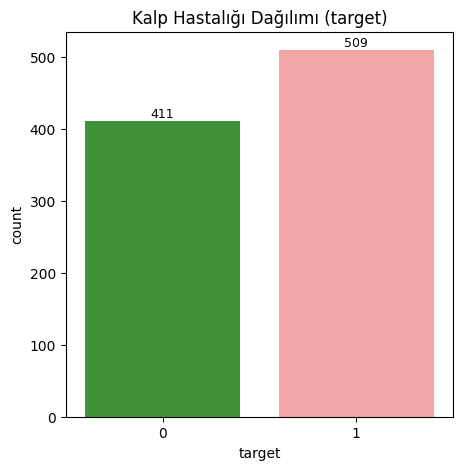

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x='target', data=df, palette=[paired_colors[3], paired_colors[4]])
for p in ax.patches:
  value = int(p.get_height())
  ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2., p.get_height()),
              ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
              textcoords='offset points')

plt.title("Kalp Hastalƒ±ƒüƒ± Daƒüƒ±lƒ±mƒ± (target)")
plt.show()

In [ ]:
# Sayƒ±sal s√ºtunlarƒ± se√ß (int64 ve float64)
num_cols = df.select_dtypes(include=['int64', 'float64'])

# Sayƒ±sal s√ºtunlarƒ±n sayƒ±sƒ±nƒ± ve adlarƒ±nƒ± satƒ±r satƒ±r g√∂r√ºnt√ºle
print(f"Toplam Sayƒ±sal S√ºtunlar: {len(num_cols.columns)}\n")
print(*num_cols.columns.tolist(), sep='\n')

Toplam Sayƒ±sal S√ºtunlar: 9

id
age
trestbps
chol
thalch
oldpeak
ca
num
target


In [ ]:
# Kategorik s√ºtunlarƒ± se√ßin (nesne, kategori, bool)
cat_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

#Kategorik s√ºtunlarƒ±n sayƒ±sƒ±nƒ± ve adlarƒ±nƒ± satƒ±r satƒ±r g√∂r√ºnt√ºle
print(f"Kategorik S√ºtunlar: {len(cat_cols)}\n")
print(*cat_cols, sep='\n')

Kategorik S√ºtunlar: 8

sex
dataset
cp
fbs
restecg
exang
slope
thal


## **Eksik Veri Analizi**

In [ ]:
#eksik veri sayƒ±sƒ±
df.isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
target        0
dtype: int64

In [ ]:
missing_percent= df.isnull().sum() / len(df) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)
print("Y√ºzdelik Olarak Eksik Verilerin Daƒüƒ±lƒ±mƒ±\n", missing_percent.sort_values(ascending=False))


Y√ºzdelik Olarak Eksik Verilerin Daƒüƒ±lƒ±mƒ±
 ca          66.413043
thal        52.826087
slope       33.586957
fbs          9.782609
oldpeak      6.739130
trestbps     6.413043
exang        5.978261
thalch       5.978261
chol         3.260870
restecg      0.217391
dtype: float64


### Fig√ºr: Y√ºzdelik Olarak Eksik Veriler

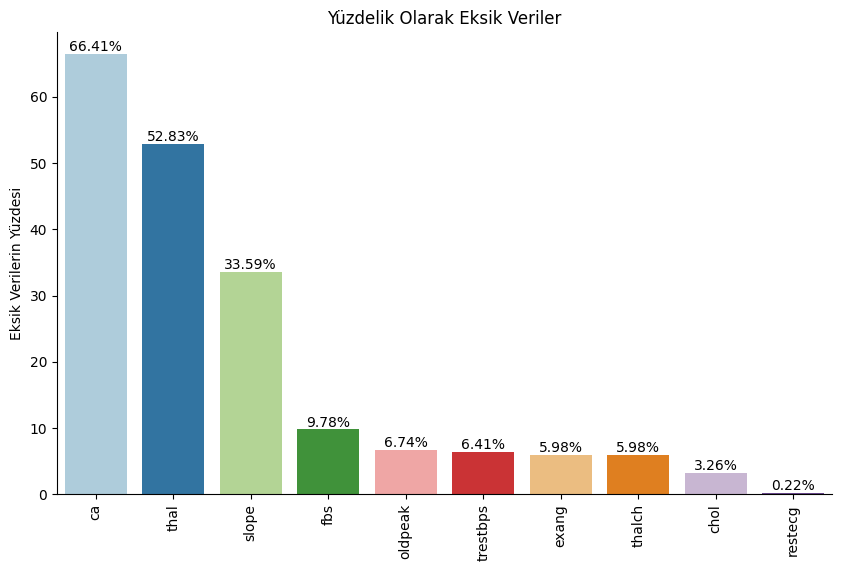

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percent.index, y=missing_percent.values, palette= paired_palette)
plt.title("Y√ºzdelik Olarak Eksik Veriler")
plt.xlabel("")
plt.ylabel("Eksik Verilerin Y√ºzdesi")
for i, v in enumerate(missing_percent.values):
    plt.text(i, v, f"{v:.2f}%", ha="center", va="bottom")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks(rotation=90)
plt.show()


### Fig√ºr: Eksik Verilerin Konumu - Heatmap

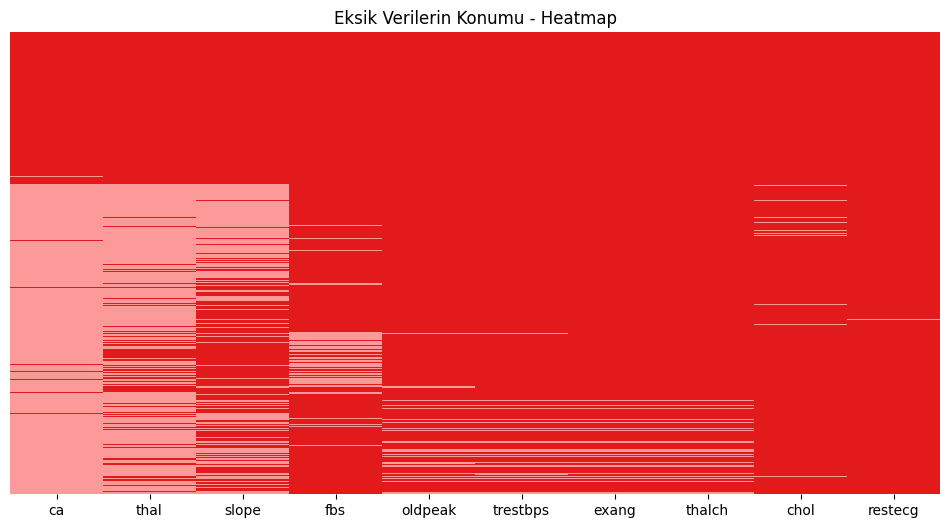

In [ ]:
# Eksik ve eksik olmayan veriler i√ßin √∂zel renkler
color_for_not_missing = "#e31a1c"  # Kƒ±rmƒ±zƒ± tonu
color_for_missing = "#fb9a99"      # Pembe tonu

custom_paired_cmap = ListedColormap([color_for_not_missing, color_for_missing])

plt.figure(figsize=(12, 6))
sns.heatmap(df[missing_percent.index].isnull(), cbar=False, yticklabels=False,
            cmap=custom_paired_cmap)
plt.title("Eksik Verilerin Konumu - Heatmap")
plt.show()

In [ ]:
# 'id', 'num', 'ca', 'thal' s√ºtunlarƒ±nƒ± d√º≈ü√ºr
df.drop(columns=["id", "num", "ca", "thal"], inplace=True)

# Sayƒ±sal veriler (KNN Imputer uygulanacak)
knn_cols = ["trestbps", "chol", "thalch", "oldpeak"]

# Kategorik veriler (mode ile doldurulacak)
mode_cols = ["slope", "fbs", "restecg", "exang"]

In [ ]:
# Sayƒ±sal ve kategorik verileri ayƒ±r
df_knn = df[knn_cols]
print("Sayƒ±sal Veriler\n", df_knn)
df_mode = df[mode_cols]
print("Kategorik Veriler\n", df_mode)

Sayƒ±sal Veriler
      trestbps   chol  thalch  oldpeak
0       145.0  233.0   150.0      2.3
1       160.0  286.0   108.0      1.5
2       120.0  229.0   129.0      2.6
3       130.0  250.0   187.0      3.5
4       130.0  204.0   172.0      1.4
..        ...    ...     ...      ...
915     127.0  333.0   154.0      0.0
916       NaN  139.0     NaN      NaN
917     122.0  223.0   100.0      0.0
918       NaN  385.0     NaN      NaN
919     120.0  254.0    93.0      0.0

[920 rows x 4 columns]
Kategorik Veriler
            slope    fbs           restecg  exang
0    downsloping   True    lv hypertrophy  False
1           flat  False    lv hypertrophy   True
2           flat  False    lv hypertrophy   True
3    downsloping  False            normal  False
4      upsloping  False    lv hypertrophy  False
..           ...    ...               ...    ...
915          NaN   True  st-t abnormality  False
916          NaN  False  st-t abnormality    NaN
917          NaN   True  st-t abnormality 

In [ ]:
# KNN Imputer uygula (sayƒ±sal)
knn_imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=knn_cols)

# Mode ile doldurma (kategorik)
mode_imputer = SimpleImputer(strategy="most_frequent")
df_mode_imputed = pd.DataFrame(mode_imputer.fit_transform(df_mode), columns=mode_cols)

# Diƒüer deƒüi≈ükenleri al
other_cols = df.drop(columns=knn_cols + mode_cols).reset_index(drop=True)

# ƒ∞mpute edilen verilerle birle≈ütir
df_cleaned = pd.concat([other_cols, df_knn_imputed, df_mode_imputed], axis=1)


In [ ]:
# Son kontrol: eksik deƒüer kalmƒ±≈ü mƒ±?
missing_summary = df_cleaned.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]
missing_summary

Series([], dtype: int64)

In [ ]:
df_cleaned.head().T

0               1               2            3  \
age                   63              67              67           37   
sex                 Male            Male            Male         Male   
dataset        Cleveland       Cleveland       Cleveland    Cleveland   
cp        typical angina    asymptomatic    asymptomatic  non-anginal   
target                 0               1               1            0   
trestbps           145.0           160.0           120.0        130.0   
chol               233.0           286.0           229.0        250.0   
thalch             150.0           108.0           129.0        187.0   
oldpeak              2.3             1.5             2.6          3.5   
slope        downsloping            flat            flat  downsloping   
fbs                 True           False           False        False   
restecg   lv hypertrophy  lv hypertrophy  lv hypertrophy       normal   
exang              False            True            True        False   

                        4  
age                    41  
sex                Female  
dataset         Cleveland  
cp        atypical angina  
target                  0  
trestbps            130.0  
chol                204.0  
thalch              172.0  
oldpeak               1.4  
slope           upsloping  
fbs                 False  
restecg    lv hypertrophy  
exang               False

Veri setinde bulunan eksik deƒüerler, yalnƒ±zca niceliksel olarak deƒüil aynƒ± zamanda **eksikliƒüin t√ºr√º** bakƒ±mƒ±ndan da analiz edilmi≈ütir. Eksik veriler √º√ß farklƒ± yapƒ±da olabilir:

* **MCAR (Missing Completely at Random):** Eksiklik tamamen rastgele, herhangi bir deƒüi≈ükenle ili≈ükili deƒüil.
* **MAR (Missing at Random):** Eksiklik ba≈üka bir g√∂zlemlenebilir deƒüi≈ükenle ili≈ükili.
* **MNAR (Missing Not at Random):** Eksiklik, deƒüi≈ükenin kendisinden kaynaklanƒ±yor.

**Deƒüerlendirme Kriterim**

Eksik veri oranƒ± √ßok y√ºksek olan bazƒ± deƒüi≈ükenlerin (√∂rneƒüin `ca` ve `thal`) rastgele eksiklenmediƒüi; hastalarƒ±n test edilmemesi, tahlil sonu√ßlarƒ±nƒ±n alƒ±nmamasƒ± gibi sistematik nedenlerle eksik olduƒüu d√º≈ü√ºn√ºlmektedir. Bu da **MNAR** olma olasƒ±lƒ±klarƒ±nƒ± artƒ±rmaktadƒ±r.

Bu durumda:

>  Bu deƒüi≈ükenleri doldurmak, ger√ßekte hi√ß yapƒ±lmamƒ±≈ü bir testin sonucunu tahmin etmek anlamƒ±na geleceƒüinden **modelin g√ºvenilirliƒüini d√º≈ü√ºrebilir**.

Dolayƒ±sƒ±yla:

* **`ca` (%66 eksik)** ve **`thal` (%53 eksik)**: Bu iki s√ºtunun eksiklik oranƒ± hem √ßok y√ºksekti hem de b√ºy√ºk olasƒ±lƒ±kla **MNAR** kategorisinde. Bu nedenle modelden √ßƒ±karƒ±lmasƒ±, daha saƒülƒ±klƒ± bir yakla≈üƒ±m oldu.

####  Doldurulan Deƒüi≈ükenler ve Nedenleri

Kalan eksik veriler (%0.2 ila %33 arasƒ±) i√ßin eksikliklerin daha √ßok **MCAR veya MAR** olduƒüu deƒüerlendirildi. √ñzellikle:

* `fbs`, `restecg`, `slope`, `exang` gibi kategorik s√ºtunlardaki eksiklikler genellikle **rastgele** g√∂r√ºnmektedir. (MCAR/MAR)
* `trestbps`, `chol`, `thalch`, `oldpeak` gibi s√ºrekli deƒüi≈ükenler ise veri yapƒ±sƒ±na baƒülƒ± olarak **yakƒ±n g√∂zlem deƒüerleri** √ºzerinden tahmin edilebilir (MAR).

Bu nedenle:

* **Sayƒ±sal Deƒüi≈ükenler i√ßin:** `KNNImputer` uygulandƒ±. Bu y√∂ntem, eksik verileri benzer g√∂zlemlerden yararlanarak doldurur. √ñzellikle MAR durumlarƒ±nda olduk√ßa ba≈üarƒ±lƒ±dƒ±r.
* **Kategorik Deƒüi≈ükenler i√ßin:** Mod (en sƒ±k g√∂r√ºlen deƒüer) ile doldurma yapƒ±ldƒ±. Bu, MCAR varsayƒ±mƒ± altƒ±nda basit ama etkili bir yakla≈üƒ±mdƒ±r.

> Sonu√ß olarak, modelin g√ºvenilirliƒüini artƒ±rmak amacƒ±yla veri seti i√ßinde yalnƒ±zca **doldurulabilir** nitelikteki eksiklikler tahmin edilerek tamamlanmƒ±≈ü, diƒüerleri ise tamamen √ßƒ±karƒ±lmƒ±≈ütƒ±r.

---



## Aykƒ±rƒ± Deƒüer Analizi

### Fig√ºr: Sayƒ±sal Deƒüi≈ükenler Arasƒ±nda Aykƒ±rƒ± Deƒüer Tespiti

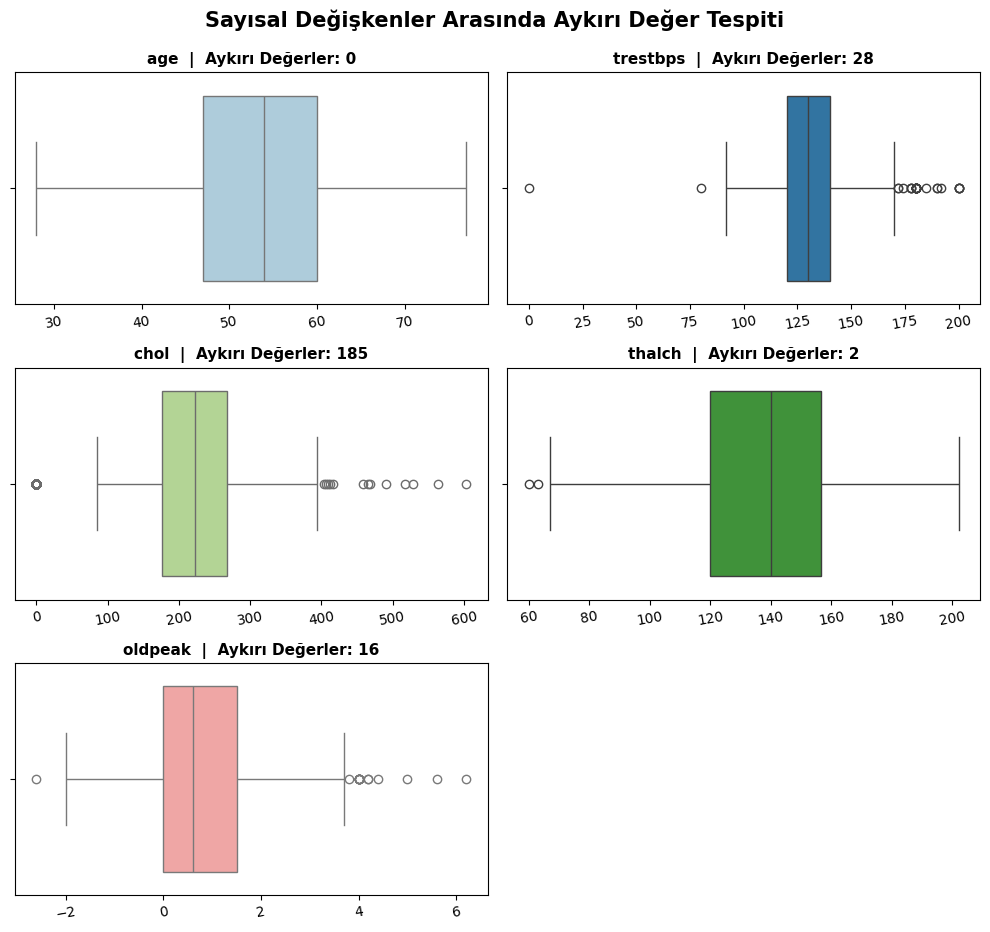

In [ ]:
# Sayƒ±sal s√ºtunlarƒ± se√ß
num_cols = df_cleaned.select_dtypes(include=["int64", "float64"]).drop(columns=["target"])

# Alt grafik yapƒ±sƒ±
num_plots = len(num_cols.columns)
cols = 2
rows = int(np.ceil(num_plots / cols))

# Grafik alanƒ± olu≈ütur
fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows))
axes = axes.flatten()

# Her bir sayƒ±sal s√ºtun i√ßin boxplot ve outlier sayƒ±sƒ±
for i, col in enumerate(num_cols.columns):
    Q1 = num_cols[col].quantile(0.25)
    Q3 = num_cols[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = ((num_cols[col] < lower_bound) | (num_cols[col] > upper_bound)).sum()

    sns.boxplot(x=num_cols[col], ax=axes[i], color=paired_colors[i])
    axes[i].set_title(f"{col}  |  Aykƒ±rƒ± Deƒüerler: {outlier_count}", fontsize=11, fontweight="bold")
    axes[i].set_xlabel("")
    axes[i].tick_params(axis='x', labelrotation=10)
    axes[i].grid(False)

# Kullanƒ±lmayan bo≈ü grafik alanlarƒ±nƒ± kaldƒ±r
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ba≈ülƒ±k ve d√ºzenleme
plt.tight_layout()
fig.suptitle('Sayƒ±sal Deƒüi≈ükenler Arasƒ±nda Aykƒ±rƒ± Deƒüer Tespiti', fontweight='bold', size=15, y=1.03)
plt.show()

In [ ]:
def winsorize_column(df_cleaned, col):
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_cleaned[col] = df_cleaned[col].apply(lambda x: upper if x > upper else (lower if x < lower else x))
    return df_cleaned


In [ ]:
def replace_outliers_with_median(df_cleaned, column):
    Q1 = df_cleaned[column].quantile(0.25)
    Q3 = df_cleaned[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    median = df_cleaned[column].median()

    df_cleaned[column] = df_cleaned[column].apply(lambda x: median if x < lower or x > upper else x)
    return df_cleaned

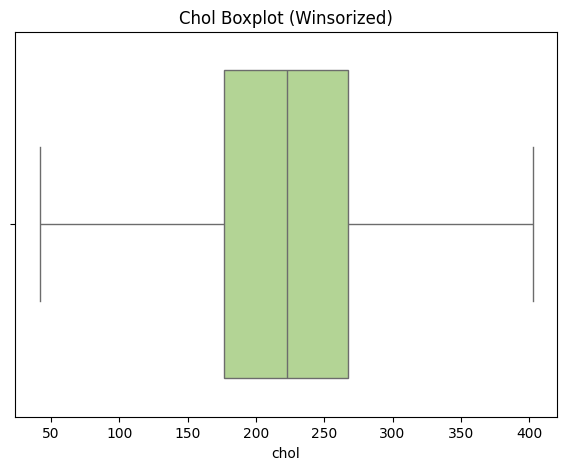

In [ ]:
# chol ‚Üí winsorize
df_cleaned = winsorize_column(df_cleaned, 'chol')

fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(x=df_cleaned['chol'], ax=ax, color=paired_colors[2])
plt.title("Chol Boxplot (Winsorized)")
plt.show()

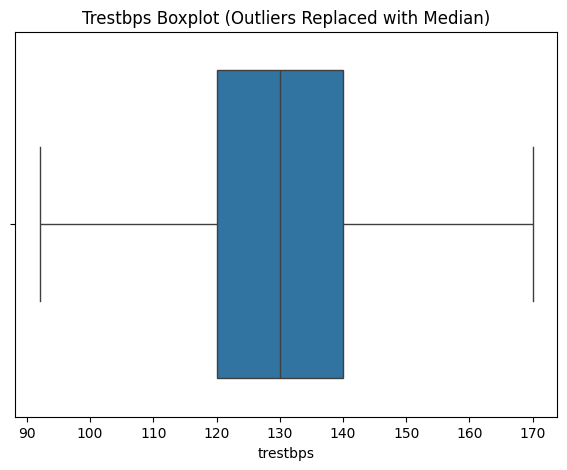

In [ ]:
#  trestbps ‚Üí aykƒ±rƒ±larƒ± medyanla deƒüi≈ütir
df_cleaned = replace_outliers_with_median(df_cleaned, 'trestbps')

fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(x=df_cleaned['trestbps'], ax=ax, color=paired_colors[1])
plt.title("Trestbps Boxplot (Outliers Replaced with Median)")
plt.show()

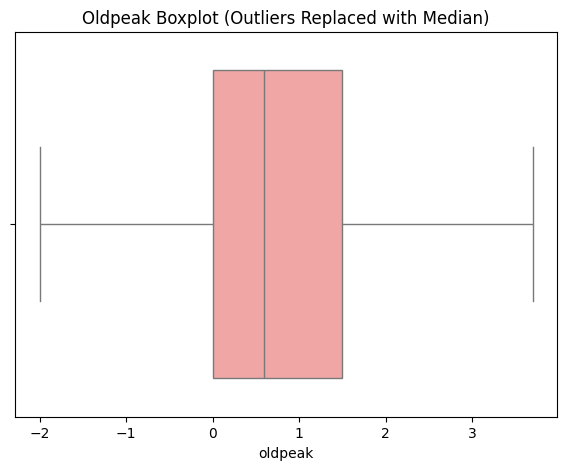

In [ ]:
# oldpeak ‚Üí aykƒ±rƒ±larƒ± medyanla deƒüi≈ütir
df_cleaned = replace_outliers_with_median(df_cleaned, 'oldpeak')

fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(x=df_cleaned['oldpeak'], ax=ax, color=paired_colors[4])
plt.title("Oldpeak Boxplot (Outliers Replaced with Median)")
plt.show()

In [ ]:
def get_outlier_summary(df_cleaned, columns):
    summary = []

    for col in columns:  # Iterate directly through the list
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outlier_count = ((df_cleaned[col] < lower) | (df_cleaned[col] > upper)).sum() # Corrected to use df_cleaned

        summary.append({
            "Deƒüi≈üken": col,
            "Aykƒ±rƒ± Deƒüer Sayƒ±sƒ±": outlier_count
        })

    return pd.DataFrame(summary).sort_values(by="Aykƒ±rƒ± Deƒüer Sayƒ±sƒ±", ascending=False)

print("Aykƒ±rƒ± Deƒüer √ñzeti:\n")

# Assuming num_cols is a list of column names you want to check for outliers
# If num_cols is not defined, you might need to get the numerical column names from df_cleaned
num_cols_for_outlier_check = df_cleaned.select_dtypes(include=["int64", "float64"]).columns.tolist()
outlier_table = get_outlier_summary(df_cleaned, num_cols_for_outlier_check)
print(outlier_table)

Aykƒ±rƒ± Deƒüer √ñzeti:

   Deƒüi≈üken  Aykƒ±rƒ± Deƒüer Sayƒ±sƒ±
4    thalch                    2
0       age                    0
1    target                    0
2  trestbps                    0
3      chol                    0
5   oldpeak                    0


1. Aykƒ±rƒ± Deƒüer ƒ∞≈üleme Stratejim ‚Äì Medikal Yakla≈üƒ±m

Veri setindeki deƒüi≈ükenlerin b√ºy√ºk √ßoƒüunluƒüu medikal parametrelerden olu≈ütuƒüu i√ßin, aykƒ±rƒ± deƒüerleri i≈ülerken istatistiksel sƒ±nƒ±rlarƒ±n yanƒ± sƒ±ra **klinik ger√ßeklikleri** de dikkate aldƒ±m. √ñzellikle:

- `chol` (kolesterol),
- `trestbps` (dinlenme kan basƒ±ncƒ±),
- `oldpeak` (egzersize baƒülƒ± ST depresyonu)

gibi deƒüi≈ükenlerde tespit edilen u√ß deƒüerler doƒürudan silinmemi≈ütir. Bu deƒüi≈ükenler, bir hastanƒ±n kardiyovask√ºler risk profilini doƒürudan etkileyebilecek √∂nemli biyobelirte√ßlerdir. Dolayƒ±sƒ±yla, her biri i√ßin ≈üu stratejiler izlenmi≈ütir:

- **`chol` i√ßin**: Winsorization y√∂ntemi uygulandƒ±. Klinik a√ßƒ±dan beklenmedik derecede y√ºksek kolesterol deƒüerleri nadiren de olsa ger√ßek olabilir. Ancak modelin √∂ƒürenmesini bozmamak adƒ±na u√ß deƒüerler sƒ±nƒ±rlandƒ±rƒ±larak korunmu≈ütur.

- **`trestbps` ve `oldpeak` i√ßin**: Aykƒ±rƒ± deƒüer sayƒ±sƒ± daha y√ºksek olduƒüu i√ßin bu deƒüerler medyanla deƒüi≈ütirildi. Medyan, saƒülƒ±k verilerinde g√ºvenilir bir temsil √∂l√ß√ºs√ºd√ºr ve ekstrem durumlarƒ±n etkisini dengelerken, verinin yapƒ±sƒ±nƒ± da korur.

- **`thalch` i√ßin**: Sadece 2 u√ß deƒüer bulundu ve bunlar muhtemelen klinik olarak anlamlƒ± istisnalardƒ±. Bu nedenle modelin genelleyici g√ºc√ºn√º artƒ±rmak adƒ±na m√ºdahale edilmedi.

- **`slope` ve `sex` gibi deƒüi≈ükenler**: Sayƒ±sal g√∂r√ºnmelerine raƒümen kategorik olduklarƒ± i√ßin aykƒ±rƒ± deƒüer analizi dƒ±≈üƒ±nda tutuldu.

Bu yakla≈üƒ±m sayesinde, hem istatistiksel g√ºvenilirlik hem de **klinik ge√ßerlilik** korunmu≈ü oldu.


# **4. G√∂rselle≈ütirme ve EDA (Ke≈üifsel Veri Analizi)**

### Figure: Sayƒ±sal Deƒüi≈ükenler Arasƒ±nda Korelasyon

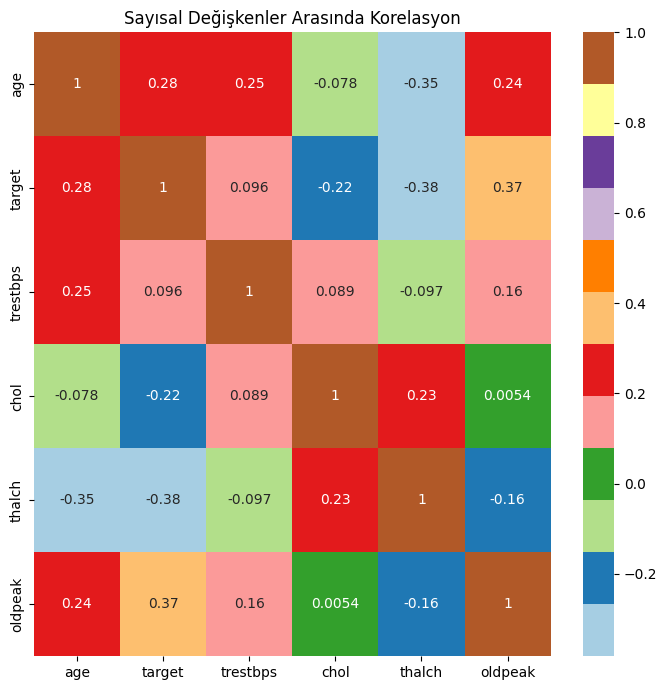

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

sns.heatmap(df_cleaned.select_dtypes(include=np.number).corr(), annot=True, cmap='Paired')
plt.title('Sayƒ±sal Deƒüi≈ükenler Arasƒ±nda Korelasyon')
plt.tight_layout()
plt.show()

 `target` (kalp hastalƒ±ƒüƒ±) ile olan korelasyonlar

- **`thalach` (maksimum kalp atƒ±≈ü hƒ±zƒ±)** ‚Üí **-0.38**:
  - Kalp hastalƒ±ƒüƒ± olan bireylerde maksimum kalp atƒ±≈ü hƒ±zƒ±nƒ±n genellikle d√º≈ü√ºk olduƒüu g√∂r√ºlm√º≈üt√ºr.
  - Bu durum, kalp hastalarƒ±nƒ±n egzersiz kapasitesinin sƒ±nƒ±rlƒ± olmasƒ±yla klinik olarak uyumludur.

- **`oldpeak` (ST depresyonu)** ‚Üí **+0.37**:
  - ST segment depresyonu arttƒ±k√ßa kalp hastalƒ±ƒüƒ± olasƒ±lƒ±ƒüƒ± da artmaktadƒ±r.
  - EKG bulgusu olarak √∂nemli bir predikt√∂rd√ºr.

- **`age` (ya≈ü)** ‚Üí **+0.28**:
  - Ya≈ü arttƒ±k√ßa kalp hastalƒ±ƒüƒ± riskinin arttƒ±ƒüƒ± g√∂r√ºlm√º≈üt√ºr.
  - Bu sonu√ß, kardiyovask√ºler risk fakt√∂rleri arasƒ±nda ya≈üƒ±n √∂nemli bir yer tuttuƒüunu doƒürulamaktadƒ±r.

- **`chol` (kolesterol)** ‚Üí **-0.22**:
  - Negatif korelasyon g√∂zlemlenmi≈ütir.
  - Bu durum, bazƒ± hastalarƒ±n ila√ß kullanƒ±mƒ±yla kolesterol deƒüerlerinin kontrol altƒ±na alƒ±nmƒ±≈ü olabileceƒüine i≈üaret edebilir.

- **`trestbps` (dinlenme kan basƒ±ncƒ±)** ‚Üí **+0.096**:
  - Kalp hastalƒ±ƒüƒ± ile zayƒ±f d√ºzeyde pozitif ili≈üki g√∂stermektedir.
  - Tansiyon tek ba≈üƒ±na g√º√ßl√º bir belirte√ß olmayabilir.

---


- **`age` ‚Äì `thalach`** ‚Üí **-0.35**:
  - Ya≈ü arttƒ±k√ßa egzersizle ula≈üƒ±lan maksimum kalp atƒ±≈ü hƒ±zƒ± d√º≈ümektedir.
  - Bu, ya≈ülanmanƒ±n fizyolojik etkilerine uygun bir bulgudur.

- **`age` ‚Äì `oldpeak`** ‚Üí **+0.24**:
  - Ya≈ülƒ± bireylerde ST segment depresyonunun daha sƒ±k g√∂r√ºld√ºƒü√ºn√º g√∂stermektedir.
  - Klinik olarak anlamlƒ± ve destekleyici bir ili≈üki.

---

 Genel Deƒüerlendirme

Bu korelasyon matrisi, √∂zellikle `thalach`, `oldpeak` ve `age` deƒüi≈ükenlerinin kalp hastalƒ±ƒüƒ±nƒ± tahmin etmede g√º√ßl√º belirleyiciler olabileceƒüini g√∂stermektedir. Modelleme s√ºrecinde bu deƒüi≈ükenlerin √∂ne √ßƒ±kmasƒ± beklenmelidir. Diƒüer yandan `chol` gibi klinik √∂nemi y√ºksek bazƒ± deƒüi≈ükenlerde d√º≈ü√ºk korelasyon bulunmasƒ±, verinin klinik ge√ßmi≈üi (ila√ß kullanƒ±mƒ±, m√ºdahale sonrasƒ± √∂l√ß√ºm vb.) ile a√ßƒ±klanabilir.



In [ ]:
num_cols2 = df_cleaned.select_dtypes(include=["int64", "float64"]).drop(columns=["target"])
len(num_cols2.columns)

5

### Fig√ºr: Sayƒ±sal Deƒüi≈ükenlerin Histogramlarƒ±

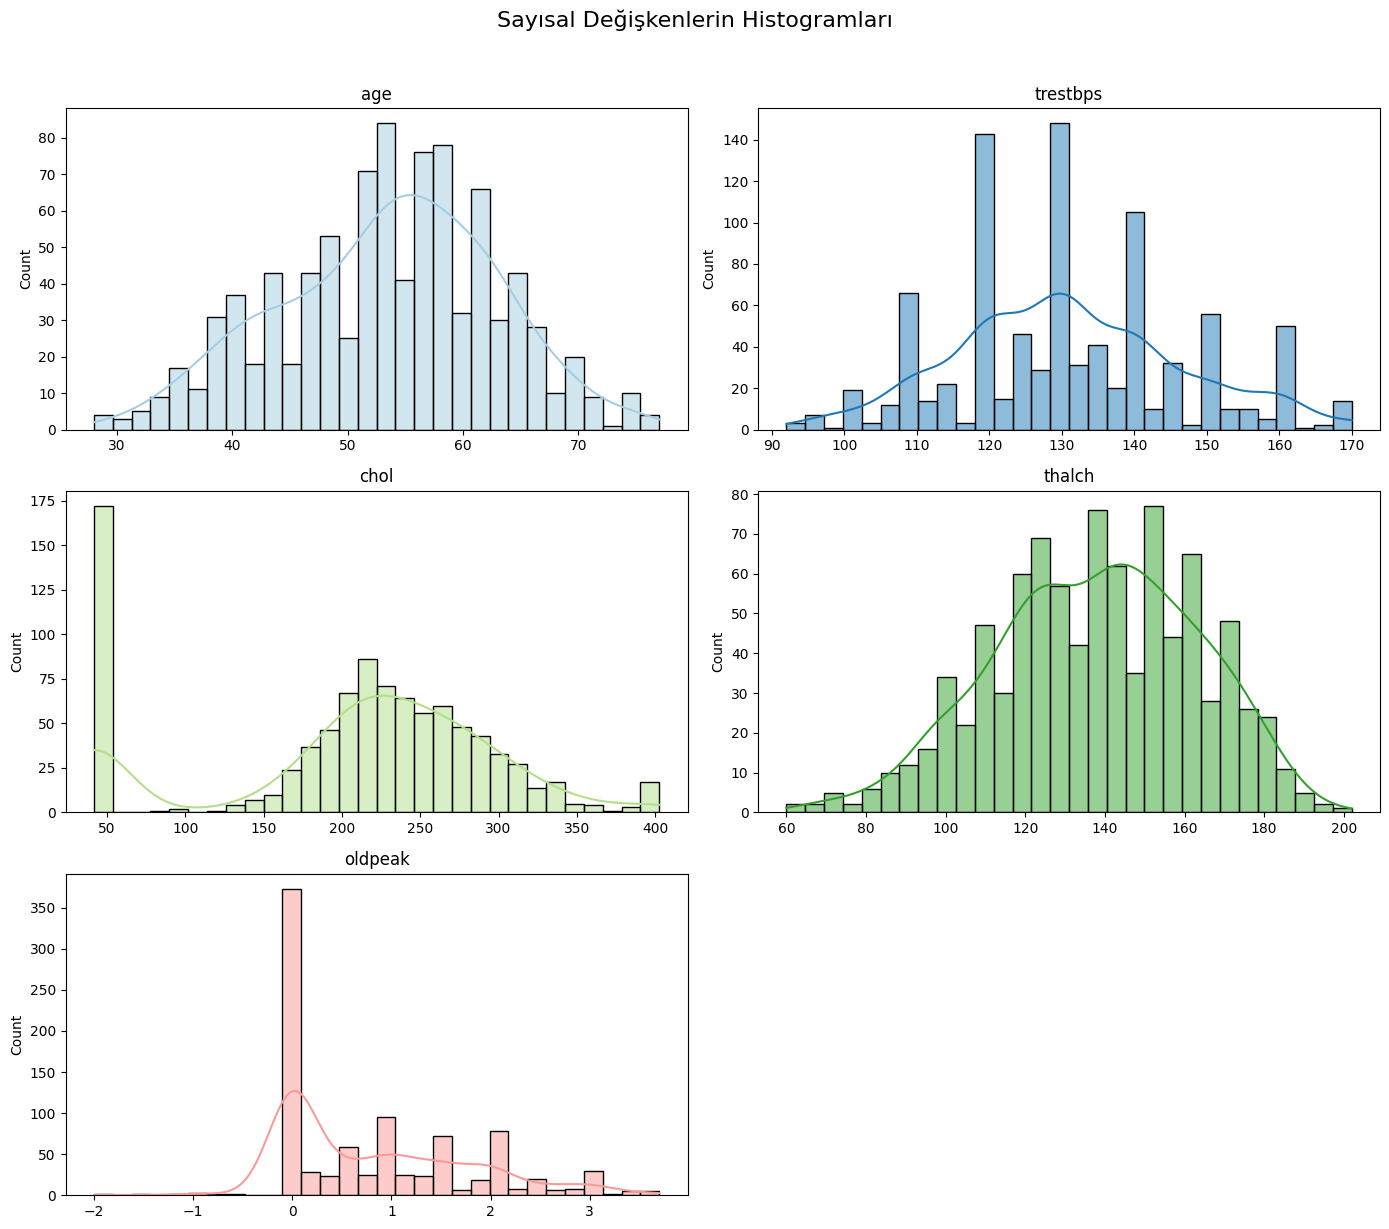

In [ ]:
colors = sns.color_palette("Paired", len(num_cols2))
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

# Her deƒüi≈üken i√ßin histogram √ßiz
for i, col in enumerate(num_cols2):
    sns.histplot(df_cleaned[col], kde=True, bins=30, color=colors[i], ax=axes[i])
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel("")

# Kullanƒ±lmayan eksik grafik alanlarƒ±nƒ± sil
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.suptitle("Sayƒ±sal Deƒüi≈ükenlerin Histogramlarƒ±", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


Yukarƒ±daki grafiklerde veri setindeki √∂nemli sayƒ±sal deƒüi≈ükenlerin histogramlarƒ± yer almaktadƒ±r. Bu g√∂rseller, deƒüi≈ükenlerin daƒüƒ±lƒ±mlarƒ±nƒ± ve aykƒ±rƒ± deƒüer eƒüilimlerini anlamamƒ±za yardƒ±mcƒ± olur.

- **age** ve **thalach** deƒüi≈ükenleri simetrik ve yakla≈üƒ±k normal daƒüƒ±lƒ±m g√∂stermektedir. Bu, modelleme s√ºrecinde bu deƒüi≈ükenlerin doƒürusallƒ±ƒüa dayalƒ± algoritmalarla uyumlu √ßalƒ±≈üabileceƒüini g√∂sterir.
  
- **trestbps** ve **chol** deƒüi≈ükenleri, merkezi eƒüilim √ßevresinde yoƒüunla≈üsa da aykƒ±rƒ± deƒüerlerin varlƒ±ƒüƒ± dikkat √ßekmektedir. Bu durum, √∂zellikle kolesterol √∂l√ß√ºmlerinde verinin saƒü kuyruklu daƒüƒ±ldƒ±ƒüƒ±nƒ± ve ekstrem deƒüerler i√ßerdiƒüini g√∂sterir.

- **oldpeak** deƒüi≈ükeni ise olduk√ßa saƒüa √ßarpƒ±k (pozitif skew) bir daƒüƒ±lƒ±ma sahiptir. Bu, hastalarda ST depresyonunun √ßoƒüunlukla 0 civarƒ±nda olduƒüu ancak az sayƒ±da y√ºksek deƒüerin bulunduƒüunu g√∂sterir.

Klinik a√ßƒ±dan bu daƒüƒ±lƒ±mlar, bir√ßok bireyin normal sƒ±nƒ±rlar i√ßinde yer aldƒ±ƒüƒ±nƒ±; ancak bazƒ± bireylerin ciddi klinik riskler ta≈üƒ±dƒ±ƒüƒ±nƒ± ortaya koymaktadƒ±r.


In [ ]:
cat_cols2= df_cleaned.select_dtypes(include=['object', 'category', 'bool'])
len(cat_cols2.columns)

7

In [ ]:
cat_cols2.head()

sex    dataset               cp        slope    fbs         restecg  \
0    Male  Cleveland   typical angina  downsloping   True  lv hypertrophy   
1    Male  Cleveland     asymptomatic         flat  False  lv hypertrophy   
2    Male  Cleveland     asymptomatic         flat  False  lv hypertrophy   
3    Male  Cleveland      non-anginal  downsloping  False          normal   
4  Female  Cleveland  atypical angina    upsloping  False  lv hypertrophy   

   exang  
0  False  
1   True  
2   True  
3  False  
4  False

### Fig√ºr: Kategorik Deƒüi≈ükenlerin Sayƒ±larƒ±

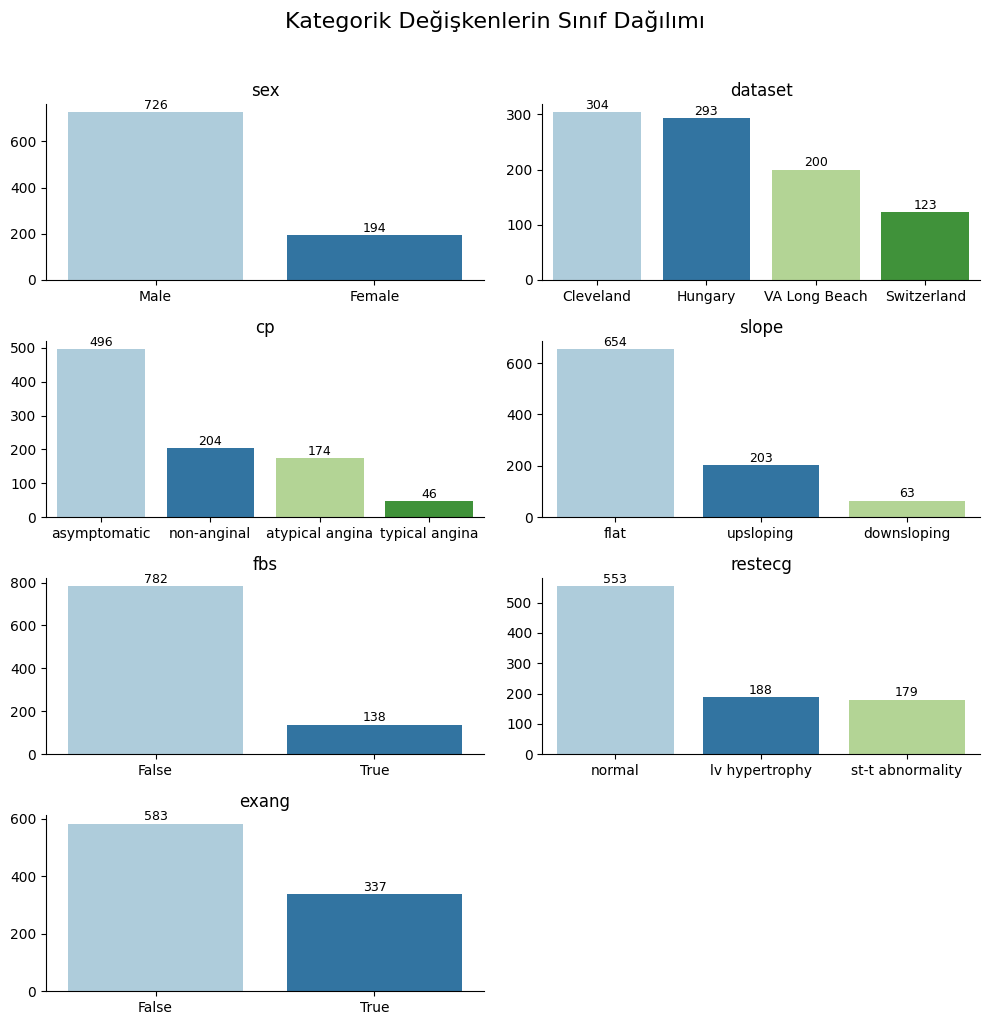

In [ ]:
colors= sns.color_palette("Paired", len(cat_cols2))

fig, axes = plt.subplots(4,2, figsize=(10,10))
axes = axes.flatten()


for i, col in enumerate(cat_cols2):
    sns.countplot(data=df_cleaned, x=col, palette=colors, ax=axes[i], order=df_cleaned[col].value_counts().index)
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

    for p in axes[i].patches:
        value = int(p.get_height())
        axes[i].annotate(f'{value}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=9, color='black',
                        xytext=(0, 5), textcoords='offset points')

for j in range(len(cat_cols2.columns), len(axes)):
    fig.delaxes(axes[j])

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.suptitle("Kategorik Deƒüi≈ükenlerin Sƒ±nƒ±f Daƒüƒ±lƒ±mƒ±", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Bu grafikler, veri setindeki kategorik deƒüi≈ükenlerin g√∂zlem sayƒ±sƒ± bakƒ±mƒ±ndan nasƒ±l daƒüƒ±ldƒ±ƒüƒ±nƒ± g√∂stermektedir.

- **sex**: Erkek bireylerin veri setinde baskƒ±n olduƒüu g√∂r√ºlmektedir. Bu durum, veri setinin toplandƒ±ƒüƒ± klinik/epidemiyolojik baƒülama baƒülƒ± olabilir ve modelleme a≈üamasƒ±nda dikkat edilmelidir.
  
- **cp (g√∂ƒü√ºs aƒürƒ±sƒ± tipi)**: En yaygƒ±n semptom "asymptomatic" olarak kodlanmƒ±≈ütƒ±r. Bu bulgu, hastalarƒ±n √ßoƒüunun g√∂ƒü√ºs aƒürƒ±sƒ± ya≈üamasa da kalp hastasƒ± olabildiƒüini g√∂stermektedir. Klinik yorum a√ßƒ±sƒ±ndan bu, sessiz iskemi olasƒ±lƒ±ƒüƒ±na i≈üaret eder.

- **slope**, **fbs**, **restecg**, **exang** gibi deƒüi≈ükenlerde de dengesiz daƒüƒ±lƒ±mlar g√∂zlemlenmi≈ütir. Bu durum, √∂zellikle dengesiz kategorilere sahip deƒüi≈ükenler i√ßin dummy encoding sonrasƒ± dikkatli modelleme gerektirir.

- **dataset** deƒüi≈ükeni, farklƒ± merkezlerden gelen veri alt k√ºmelerini temsil eder. Buradaki dengesizlik, hastalƒ±k oranlarƒ±nda merkezler arasƒ± farklƒ±lƒ±klara da neden olabilir.

Veri daƒüƒ±lƒ±mlarƒ±nƒ±n bu ≈üekilde analiz edilmesi, hem √∂n i≈üleme adƒ±mlarƒ±nda hem de model yorumlamalarƒ±nda yanlƒ±≈ü genellemeleri √∂nlemek a√ßƒ±sƒ±ndan olduk√ßa √∂nemlidir.


### Fig√ºr: Kategorik Deƒüi≈ükenlerde Kalp Hastalƒ±ƒüƒ± (target=1) Oranlarƒ±

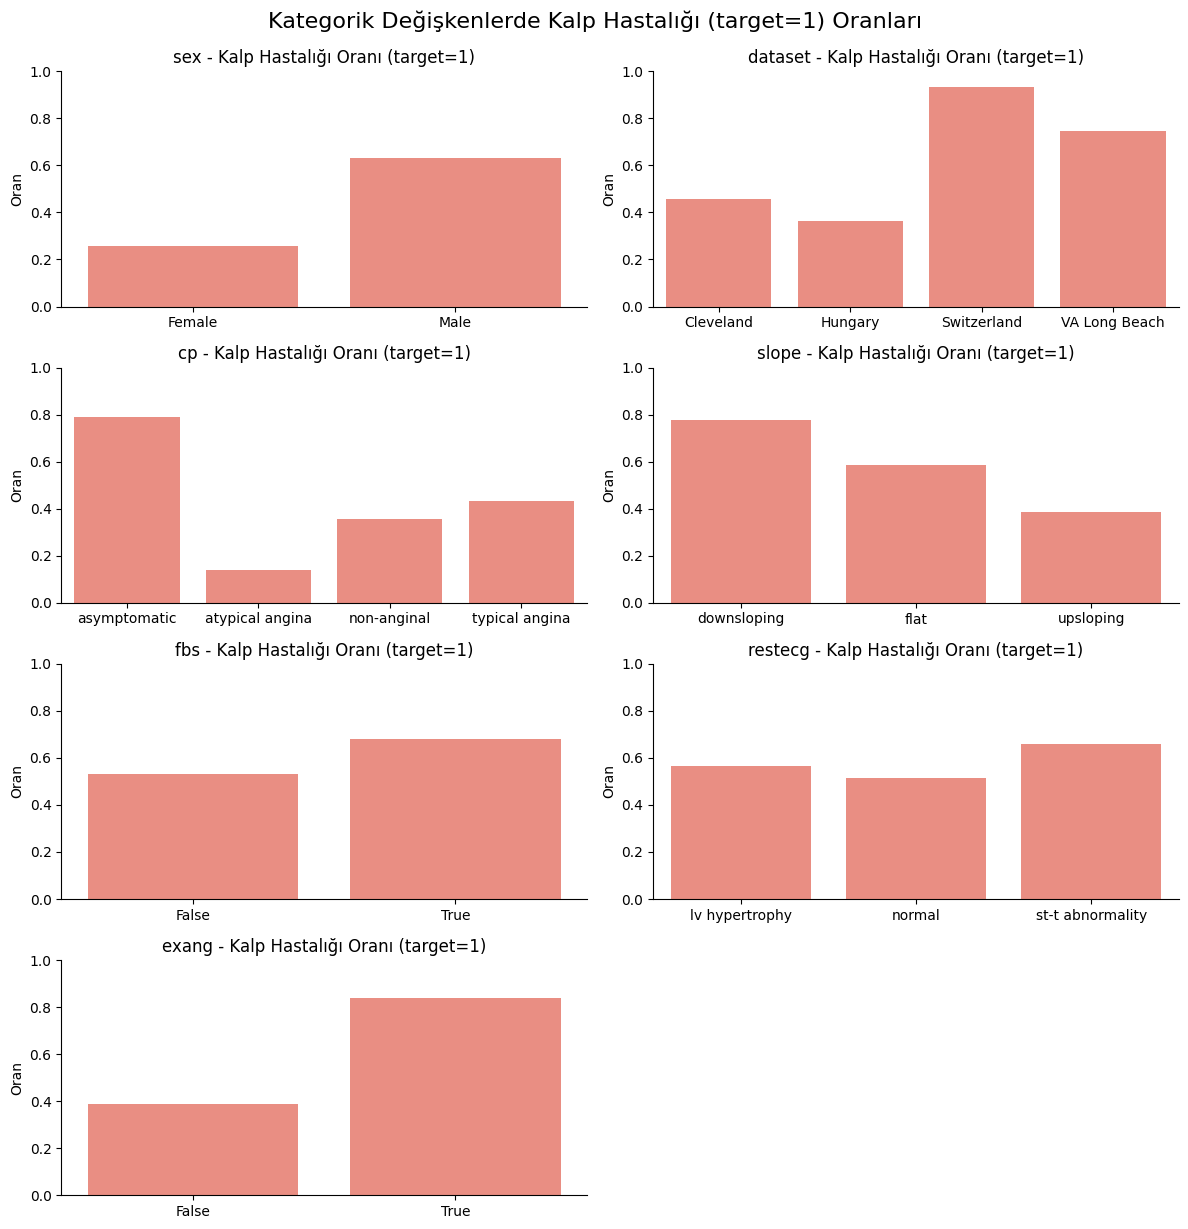

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(12, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols2.columns):
    # target=1 oranƒ±nƒ± al
    proportions = df_cleaned.groupby(col)['target'].mean()

    sns.barplot(x=proportions.index, y=proportions.values, ax=axes[i], color="salmon")
    axes[i].set_ylim(0, 1)
    axes[i].set_title(f"{col} - Kalp Hastalƒ±ƒüƒ± Oranƒ± (target=1)")
    axes[i].set_ylabel("Oran")
    axes[i].set_xlabel("")
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

# Eksikleri sil
for j in range(len(cat_cols2.columns), len(axes)):
    fig.delaxes(axes[j])

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.tight_layout()
plt.suptitle("Kategorik Deƒüi≈ükenlerde Kalp Hastalƒ±ƒüƒ± (target=1) Oranlarƒ±", fontsize=16, y=1.02)
plt.show()


Bu analiz, her kategorik deƒüi≈ükenin sƒ±nƒ±flarƒ± i√ßinde kalp hastalƒ±ƒüƒ± oranlarƒ±nƒ± (target = 1) kar≈üƒ±la≈ütƒ±rmalƒ± olarak sunmaktadƒ±r. Klinik bakƒ±≈ü a√ßƒ±sƒ±yla modelin √∂nemli sinyalleri ≈üunlardƒ±r:

- **sex**: Erkek bireylerde kalp hastalƒ±ƒüƒ± oranƒ± kadƒ±nlara g√∂re daha y√ºksektir. Bu, kardiyovask√ºler riskin erkeklerde daha belirgin olduƒüunu g√∂steren literat√ºrle uyumludur.

- **cp (g√∂ƒü√ºs aƒürƒ±sƒ± tipi)**: "Asymptomatic" sƒ±nƒ±fƒ±nda kalp hastalƒ±ƒüƒ± oranƒ± a√ßƒ±k√ßa y√ºksektir. Bu durum, g√∂ƒü√ºs aƒürƒ±sƒ± ya≈üamayan ama ciddi kardiyovask√ºler risk ta≈üƒ±yan bireylerin varlƒ±ƒüƒ±nƒ± g√∂sterir ve klinik a√ßƒ±dan sessiz iskemi vakalarƒ±na i≈üaret eder.

- **exang (egzersiz anƒ±nda anjina)**: Egzersiz sƒ±rasƒ±nda anjina ya≈üayan bireylerde kalp hastalƒ±ƒüƒ± oranƒ± √ßok y√ºksektir. Bu, efor testi bulgularƒ±nƒ±n √∂nemini vurgular.

- **slope**: "Downsloping" ST segment deƒüi≈üimi g√∂steren bireylerde kalp hastalƒ±ƒüƒ± oranƒ± daha y√ºksektir. Bu, EKG yorumlamalarƒ±nda √∂nemli bir bulgudur.

- **dataset**: Verinin geldiƒüi merkeze g√∂re hastalƒ±k oranlarƒ±nda ciddi farklar g√∂zlemlenmi≈ütir. Bu durum, merkeze √∂zg√º klinik protokoller veya demografik yapƒ±nƒ±n etkisiyle a√ßƒ±klanabilir.

Bu analiz sayesinde hangi kategorik deƒüi≈ükenlerin kalp hastalƒ±ƒüƒ± √ºzerinde belirgin etkisi olduƒüu tespit edilmi≈ütir. Bu deƒüi≈ükenler modelin √∂ne √ßƒ±kan girdileri olarak deƒüerlendirilebilir.


# 5.Veri √ñn ƒ∞≈üleme

* Kategorik verileri encode et:

  * LabelEncoder (sƒ±ralƒ± verilerde)
  * OneHotEncoder (sƒ±rasƒ±z verilerde)
* Sayƒ±sal verileri √∂l√ßekle:

  * StandardScaler, MinMaxScaler (√∂zellikle distance-based modeller i√ßin)

In [ ]:
print("Temizlenmi≈ü verimizin deƒüi≈ükenleri:\n",df_cleaned.columns)

Temizlenmi≈ü verimizin deƒüi≈ükenleri:
 Index(['age', 'sex', 'dataset', 'cp', 'target', 'trestbps', 'chol', 'thalch',
       'oldpeak', 'slope', 'fbs', 'restecg', 'exang'],
      dtype='object')


In [ ]:
print("Kategorik Deƒüi≈ükenler:\n", cat_cols2.columns)
print("Sayƒ±sal Deƒüi≈ükenler:\n", num_cols2.columns)

Kategorik Deƒüi≈ükenler:
 Index(['sex', 'dataset', 'cp', 'slope', 'fbs', 'restecg', 'exang'], dtype='object')
Sayƒ±sal Deƒüi≈ükenler:
 Index(['age', 'trestbps', 'chol', 'thalch', 'oldpeak'], dtype='object')


**Label Encode**

In [ ]:
# Label Encoding uygulanacak s√ºtunlar
label_cols = ['sex', 'fbs', 'exang']

for col in label_cols:
    print(f"--- Label Encoder √ñNCESƒ∞ ---")
    print(f"Deƒüi≈üken: '{col}'")
    print("Benzersiz deƒüerler (√∂nce):", df_cleaned[col].unique())

    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])

    print(f"\n--- Label Encoder SONRASI ---")
    print(f"Deƒüi≈üken: '{col}'")
    print("Benzersiz deƒüerler (sonra):", df_cleaned[col].unique())
    print("Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
    print("\n" + "-"*50 + "\n")


--- Label Encoder √ñNCESƒ∞ ---
Deƒüi≈üken: 'sex'
Benzersiz deƒüerler (√∂nce): ['Male' 'Female']

--- Label Encoder SONRASI ---
Deƒüi≈üken: 'sex'
Benzersiz deƒüerler (sonra): [1 0]
Mapping: {'Female': np.int64(0), 'Male': np.int64(1)}

--------------------------------------------------

--- Label Encoder √ñNCESƒ∞ ---
Deƒüi≈üken: 'fbs'
Benzersiz deƒüerler (√∂nce): [True False]

--- Label Encoder SONRASI ---
Deƒüi≈üken: 'fbs'
Benzersiz deƒüerler (sonra): [1 0]
Mapping: {False: np.int64(0), True: np.int64(1)}

--------------------------------------------------

--- Label Encoder √ñNCESƒ∞ ---
Deƒüi≈üken: 'exang'
Benzersiz deƒüerler (√∂nce): [False True]

--- Label Encoder SONRASI ---
Deƒüi≈üken: 'exang'
Benzersiz deƒüerler (sonra): [0 1]
Mapping: {False: np.int64(0), True: np.int64(1)}

--------------------------------------------------



**`sex` (Cinsiyet)**

| √ñnce      | Sonra |
| --------- | ----- |
| 0 (Kadƒ±n) | 0     |
| 1 (Erkek) | 1     |

> `sex` s√ºtunu daha √∂nce zaten sayƒ±sal olarak 0/1 ≈üeklindeydi, bu y√ºzden Label Encoder herhangi bir d√∂n√º≈ü√ºm yapmadan mevcut haliyle e≈üle≈ütirdi.

---

**`fbs` (A√ßlƒ±k Kan ≈ûekeri > 120 mg/dl)**

| √ñnce  | Sonra |
| ----- | ----- |
| False | 0     |
| True  | 1     |

> `fbs` binary (doƒüru/yanlƒ±≈ü) yapƒ±da olduƒüu i√ßin Label Encoding ile sayƒ±sal hale getirildi.

---

**`exang` (Egzersize Baƒülƒ± Anjina)**

| √ñnce  | Sonra |
| ----- | ----- |
| False | 0     |
| True  | 1     |

> `exang` da binary bir s√ºtun olduƒüundan, doƒürudan 0 ve 1 olarak etiketlendi.

---
Modelin sayƒ±sal verilerle √ßalƒ±≈üabilmesi i√ßin, sex, fbs ve exang gibi binary deƒüi≈ükenlere Label Encoding uyguladƒ±m.
Bu s√ºtunlar zaten iki sƒ±nƒ±flƒ± olduƒüu i√ßin, LabelEncoder onlarƒ± 0 ve 1 olarak sade bir bi√ßimde d√∂n√º≈üt√ºrd√º. Bu sayede veri formatƒ±nƒ± korurken modelin bu deƒüi≈ükenleri anlamasƒ±nƒ± saƒüladƒ±m.

**One Hot Encoding**

In [ ]:
# Encoding √∂ncesi benzersiz deƒüer kontrol√º
cols_to_encode = ['dataset', 'cp', 'restecg', 'slope']

print(" --- One-Hot Encoding √ñNCESƒ∞ ---")
for col in cols_to_encode:
    print(f"Deƒüi≈üken: '{col}' - Benzersiz Deƒüerler: {df_cleaned[col].unique()}")

# One-Hot Encoding i≈ülemi
df_encoded = pd.get_dummies(df_cleaned, columns=cols_to_encode, drop_first=True)

print("\n --- One-Hot Encoding SONRASI ---")
print("Yeni s√ºtunlar:", [col for col in df_encoded.columns if any(prefix in col for prefix in cols_to_encode)])


 --- One-Hot Encoding √ñNCESƒ∞ ---
Deƒüi≈üken: 'dataset' - Benzersiz Deƒüerler: ['Cleveland' 'Hungary' 'Switzerland' 'VA Long Beach']
Deƒüi≈üken: 'cp' - Benzersiz Deƒüerler: ['typical angina' 'asymptomatic' 'non-anginal' 'atypical angina']
Deƒüi≈üken: 'restecg' - Benzersiz Deƒüerler: ['lv hypertrophy' 'normal' 'st-t abnormality']
Deƒüi≈üken: 'slope' - Benzersiz Deƒüerler: ['downsloping' 'flat' 'upsloping']

 --- One-Hot Encoding SONRASI ---
Yeni s√ºtunlar: ['dataset_Hungary', 'dataset_Switzerland', 'dataset_VA Long Beach', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'restecg_normal', 'restecg_st-t abnormality', 'slope_flat', 'slope_upsloping']


**Encoding √ñncesi Benzersiz Deƒüerler:**

| Deƒüi≈üken  | Sƒ±nƒ±flar                                                   |
| --------- | ---------------------------------------------------------- |
| `dataset` | Cleveland, Hungary, Switzerland, VA Long Beach             |
| `cp`      | typical angina, asymptomatic, non-anginal, atypical angina |
| `restecg` | lv hypertrophy, normal, st-t abnormality                   |
| `slope`   | downsloping, flat, upsloping                               |

**Encoding Sonrasƒ± Olu≈üan Yeni S√ºtunlar:**

```text
['dataset_Hungary',
 'dataset_Switzerland',
 'dataset_VA Long Beach',
 'cp_atypical angina',
 'cp_non-anginal',
 'cp_typical angina',
 'restecg_normal',
 'restecg_st-t abnormality',
 'slope_flat',
 'slope_upsloping']
```

> `drop_first=True` parametresi ile her kategorik deƒüi≈ükende **bir sƒ±nƒ±f referans olarak d√º≈ü√ºr√ºlm√º≈ü** ve b√∂ylece **√ßoklu doƒürusal baƒülantƒ± (multicollinearity)** riski azaltƒ±lmƒ±≈ütƒ±r.

---
> ‚Äú`cp`, `slope`, `dataset` ve `restecg` gibi sƒ±ralƒ± anlam ta≈üƒ±mayan kategorik deƒüi≈ükenlerde one-hot encoding uyguladƒ±m. B√∂ylece model bu deƒüi≈ükenleri e≈üit mesafede ve kar≈üƒ±la≈ütƒ±rƒ±labilir olarak ele alabiliyor.
> Ayrƒ±ca `drop_first=True` parametresi ile referans sƒ±nƒ±fƒ± bƒ±rakarak fazladan bilgi tekrarƒ±nƒ±n √∂n√ºne ge√ßtim.‚Äù




**StandardScaler**

In [ ]:
# √ñl√ßeklenecek sayƒ±sal s√ºtunlar
num_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']

scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

print(" Sayƒ±sal deƒüi≈ükenler √∂l√ßeklendi.")

 Sayƒ±sal deƒüi≈ükenler √∂l√ßeklendi.



| Deƒüi≈üken   | A√ßƒ±klama                                   |
| ---------- | ------------------------------------------ |
| `age`      | Hastanƒ±n ya≈üƒ±                              |
| `trestbps` | Dinlenme kan basƒ±ncƒ±                       |
| `chol`     | Serum kolesterol d√ºzeyi                    |
| `thalch`   | Egzersiz sƒ±rasƒ±nda ula≈üƒ±lan maksimum nabƒ±z |
| `oldpeak`  | ST depresyonu                              |

----


* Kullanƒ±lan y√∂ntem: **StandardScaler**
* Form√ºl: (x - ortalama) / standart sapma
* Her deƒüi≈üken, ortalamasƒ± 0 ve standart sapmasƒ± 1 olacak ≈üekilde yeniden √∂l√ßeklendirildi.

----


> Sayƒ±sal deƒüi≈ükenlerin farklƒ± √∂l√ßeklerde olmasƒ± modelin √∂ƒürenmesini zorla≈ütƒ±rabileceƒüi i√ßin, √∂zellikle regresyon ve mesafe tabanlƒ± algoritmalarda yaygƒ±n kullanƒ±lan StandardScaler y√∂ntemini tercih ettim. Bu y√∂ntemle her deƒüi≈ükenin daƒüƒ±lƒ±mƒ±nƒ± normalize ederek modelin her √∂zelliƒüe e≈üit mesafede yakla≈ümasƒ±nƒ± saƒüladƒ±m.

In [ ]:
print("Modelleme √∂ncesi verimiz b√∂yle:\n")
display(df_cleaned.head().T)
print("\n")
print("Modelleme sonrasƒ± verimiz b√∂yle:\n")
display(df_encoded.head().T)

Modelleme √∂ncesi verimiz b√∂yle:



0               1               2            3  \
age                   63              67              67           37   
sex                    1               1               1            1   
dataset        Cleveland       Cleveland       Cleveland    Cleveland   
cp        typical angina    asymptomatic    asymptomatic  non-anginal   
target                 0               1               1            0   
trestbps           145.0           160.0           120.0        130.0   
chol               233.0           286.0           229.0        250.0   
thalch             150.0           108.0           129.0        187.0   
oldpeak              2.3             1.5             2.6          3.5   
slope        downsloping            flat            flat  downsloping   
fbs                    1               0               0            0   
restecg   lv hypertrophy  lv hypertrophy  lv hypertrophy       normal   
exang                  0               1               1            0   

                        4  
age                    41  
sex                     0  
dataset         Cleveland  
cp        atypical angina  
target                  0  
trestbps            130.0  
chol                204.0  
thalch              172.0  
oldpeak               1.4  
slope           upsloping  
fbs                     0  
restecg    lv hypertrophy  
exang                   0



Modelleme sonrasƒ± verimiz b√∂yle:



0         1         2         3         4
age                       1.007386  1.432034  1.432034 -1.752828  -1.32818
sex                              1         1         1         1         0
target                           0         1         1         0         0
trestbps                  0.903911  1.864748 -0.697484 -0.056926 -0.056926
chol                      0.285405  0.858419  0.242158  0.469201 -0.028131
thalch                    0.485469 -1.172119 -0.343325  1.945726   1.35373
oldpeak                    1.54997  0.710511  1.864767  2.809158  0.605578
fbs                              1         0         0         0         0
exang                            0         1         1         0         0
dataset_Hungary              False     False     False     False     False
dataset_Switzerland          False     False     False     False     False
dataset_VA Long Beach        False     False     False     False     False
cp_atypical angina           False     False     False     False      True
cp_non-anginal               False     False     False      True     False
cp_typical angina             True     False     False     False     False
restecg_normal               False     False     False      True     False
restecg_st-t abnormality     False     False     False     False     False
slope_flat                   False      True      True     False     False
slope_upsloping              False     False     False     False      True

In [ ]:
print("Modelleme √∂ncesi verimiz b√∂yle:\n")
display(df_cleaned.describe().T)
print("\n")
print("Modelleme sonrasƒ± verimiz b√∂yle:\n")
display(df_encoded.describe().T)

Modelleme √∂ncesi verimiz b√∂yle:



count        mean        std     min    25%    50%     75%      max
age       920.0   53.510870   9.424685  28.000   47.0   54.0   60.00   77.000
sex       920.0    0.789130   0.408148   0.000    1.0    1.0    1.00    1.000
target    920.0    0.553261   0.497426   0.000    0.0    1.0    1.00    1.000
trestbps  920.0  130.888693  15.619884  92.000  120.0  130.0  140.00  170.000
chol      920.0  206.601974  92.543684  41.625  177.0  223.0  267.25  402.625
thalch    920.0  137.699171  25.351797  60.000  120.0  140.0  156.40  202.000
oldpeak   920.0    0.822887   0.953513  -2.000    0.0    0.6    1.50    3.700
fbs       920.0    0.150000   0.357266   0.000    0.0    0.0    0.00    1.000
exang     920.0    0.366304   0.482056   0.000    0.0    0.0    1.00    1.000



Modelleme sonrasƒ± verimiz b√∂yle:



count          mean       std       min       25%       50%  \
age       920.0  6.178632e-17  1.000544 -2.708286 -0.691207  0.051927   
sex       920.0  7.891304e-01  0.408148  0.000000  1.000000  1.000000   
target    920.0  5.532609e-01  0.497426  0.000000  0.000000  1.000000   
trestbps  920.0 -3.475481e-16  1.000544 -2.491046 -0.697484 -0.056926   
chol      920.0  1.235726e-16  1.000544 -1.783663 -0.320044  0.177289   
thalch    920.0  4.325043e-16  1.000544 -3.066506 -0.698522  0.090805   
oldpeak   920.0  9.267949e-17  1.000544 -2.962123 -0.863475 -0.233881   
fbs       920.0  1.500000e-01  0.357266  0.000000  0.000000  0.000000   
exang     920.0  3.663043e-01  0.482056  0.000000  0.000000  0.000000   

               75%       max  
age       0.688899  2.493654  
sex       1.000000  1.000000  
target    1.000000  1.000000  
trestbps  0.583632  2.505305  
chol      0.655701  2.119320  
thalch    0.738054  2.537722  
oldpeak   0.710511  3.019023  
fbs       0.000000  1.000000  
exang     1.000000  1.000000

Modelleme √ñncesi ve Sonrasƒ± Veri Kar≈üƒ±la≈ütƒ±rmasƒ±

A≈üaƒüƒ±daki tabloda, veride modelleme √∂ncesi ve sonrasƒ±nda yapƒ±lan i≈ülemlerin etkisi a√ßƒ±k√ßa g√∂r√ºl√ºyor:

| √ñzellik    | Modelleme √ñncesi (mean ¬± std) | Modelleme Sonrasƒ± (mean ¬± std) | A√ßƒ±klama                             |
| ---------- | ----------------------------- | ------------------------------ | ------------------------------------ |
| `age`      | 53.5 ¬± 9.42                   | \~0 ¬± 1.00                     | StandardScaler uygulandƒ±             |
| `trestbps` | 130.9 ¬± 15.62                 | \~0 ¬± 1.00                     | StandardScaler uygulandƒ±             |
| `chol`     | 206.6 ¬± 92.54                 | \~0 ¬± 1.00                     | StandardScaler uygulandƒ±             |
| `thalch`   | 137.7 ¬± 25.35                 | \~0 ¬± 1.00                     | StandardScaler uygulandƒ±             |
| `oldpeak`  | 0.82 ¬± 0.95                   | \~0 ¬± 1.00                     | StandardScaler uygulandƒ±             |
| `sex`      | 0.79 ¬± 0.41                   | Aynƒ± kaldƒ± (Label encoded)     | Binary olduƒüu i√ßin scaling gerekmedi |
| `fbs`      | 0.15 ¬± 0.36                   | Aynƒ± kaldƒ± (Label encoded)     | Binary                               |
| `exang`    | 0.37 ¬± 0.48                   | Aynƒ± kaldƒ± (Label encoded)     | Binary                               |
| `target`   | 0.55 ¬± 0.50                   | Aynƒ± (deƒüi≈ütirilmedi)          | Hedef deƒüi≈üken                       |

---

* Sayƒ±sal s√ºtunlarƒ±n hepsi **ba≈üarƒ±yla normalize edildi** (ortalama ‚âà 0, std ‚âà 1).
* Binary deƒüi≈ükenler (`sex`, `fbs`, `exang`) zaten 0‚Äì1 formatƒ±nda olduƒüundan scaling'e gerek kalmadƒ±.
* `target` s√ºtunu (yani modelin tahmin etmeye √ßalƒ±≈ütƒ±ƒüƒ± deƒüi≈üken) olduƒüu gibi bƒ±rakƒ±ldƒ±.

---

 Modellemeye ge√ßmeden √∂nce verinin son halini tek tek kontrol ettim. Sayƒ±sal deƒüi≈ükenlerde standardizasyon (scaling) i≈ülemi yaparak hepsini aynƒ± √∂l√ßeƒüe getirdim. B√∂ylece modelin bazƒ± deƒüi≈ükenleri diƒüerlerinden daha ‚Äú√∂nemliymi≈ü‚Äù gibi algƒ±lamasƒ±nƒ±n √∂n√ºne ge√ßtim.

`sex`, `fbs` ve `exang` gibi zaten binary olan s√ºtunlar label encoding ile sayƒ±salla≈ütƒ±rƒ±ldƒ±ƒüƒ± i√ßin onlara scaling uygulamama gerek kalmadƒ±.

 Sonu√ß olarak t√ºm verim hem mantƒ±klƒ± hem de makine √∂ƒürenmesine uygun bir forma d√∂n√º≈üt√º.




### Fig√ºr: √ñzelliklerin Standart Sapmalarƒ±ndaki Deƒüi≈üim (StandardScaler Uygulamasƒ±)

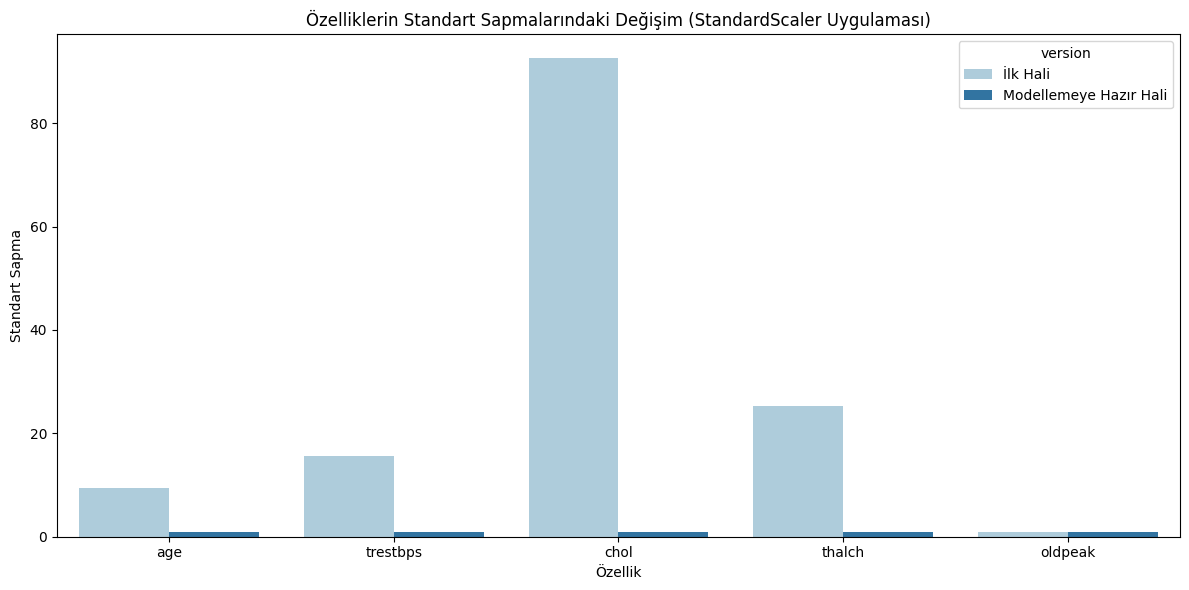

In [ ]:
# 1. Verinin ilk haline ait describe() √ßƒ±ktƒ±sƒ±na g√∂re standart sapmalar
first_desc = {
    'age': {'std': 9.42},
    'trestbps': {'std': 15.62},
    'chol': {'std': 92.54},
    'thalch': {'std': 25.35},
    'oldpeak': {'std': 0.95}
}

# 2. StandardScaler sonrasƒ± veriye ait describe() √ßƒ±ktƒ±sƒ±na g√∂re standart sapmalar
scaled_desc = {
    'age': {'std': 1.00},
    'trestbps': {'std': 1.00},
    'chol': {'std': 1.00},
    'thalch': {'std': 1.00},
    'oldpeak': {'std': 1.00}
}

# 3. DataFrame olu≈ütur
initial_df = pd.DataFrame(first_desc).T
initial_df['version'] = 'ƒ∞lk Hali'

scaled_df = pd.DataFrame(scaled_desc).T
scaled_df['version'] = 'Modellemeye Hazƒ±r Hali'

# 4. Birle≈ütir
combined_df = pd.concat([initial_df, scaled_df]).reset_index().rename(columns={'index': 'feature'})

# 5. G√∂rselle≈ütir
plt.figure(figsize=(12, 6))
sns.barplot(data=combined_df, x='feature', y='std', hue='version', palette='Paired')
plt.title('√ñzelliklerin Standart Sapmalarƒ±ndaki Deƒüi≈üim (StandardScaler Uygulamasƒ±)')
plt.ylabel('Standart Sapma')
plt.xlabel('√ñzellik')
plt.tight_layout()
plt.show()

* `chol`, `thalch`, `trestbps` gibi bazƒ± deƒüi≈ükenlerde standart sapma **√ßok y√ºksek** olduƒüu i√ßin bu deƒüi≈ükenler model √ºzerinde baskƒ±n hale gelebilirdi.
* StandardScaler uygulandƒ±ktan sonra t√ºm deƒüi≈ükenlerin daƒüƒ±lƒ±mlarƒ± normalize edildi (**std ‚âà 1**), b√∂ylece model her deƒüi≈ükene e≈üit hassasiyetle yakla≈üabilecek hale geldi.
---

* Bu grafikte g√∂rd√ºƒü√ºm√ºz gibi, veri setimde bazƒ± sayƒ±sal deƒüi≈ükenlerin standart sapmalarƒ± olduk√ßa farklƒ±ydƒ±. Bu farklar modelin √∂ƒürenmesini olumsuz etkileyebileceƒüi i√ßin StandardScaler kullandƒ±m.
* Sonu√ß olarak, t√ºm deƒüi≈ükenleri aynƒ± √∂l√ßeƒüe √ßekerek modeli daha dengeli ve doƒüru √∂ƒürenebilecek bir yapƒ±ya ula≈ütƒ±rdƒ±m.


### Fig√ºr: StandardScaler Uygulamasƒ±: Daƒüƒ±lƒ±m √úzerindeki Etkisi

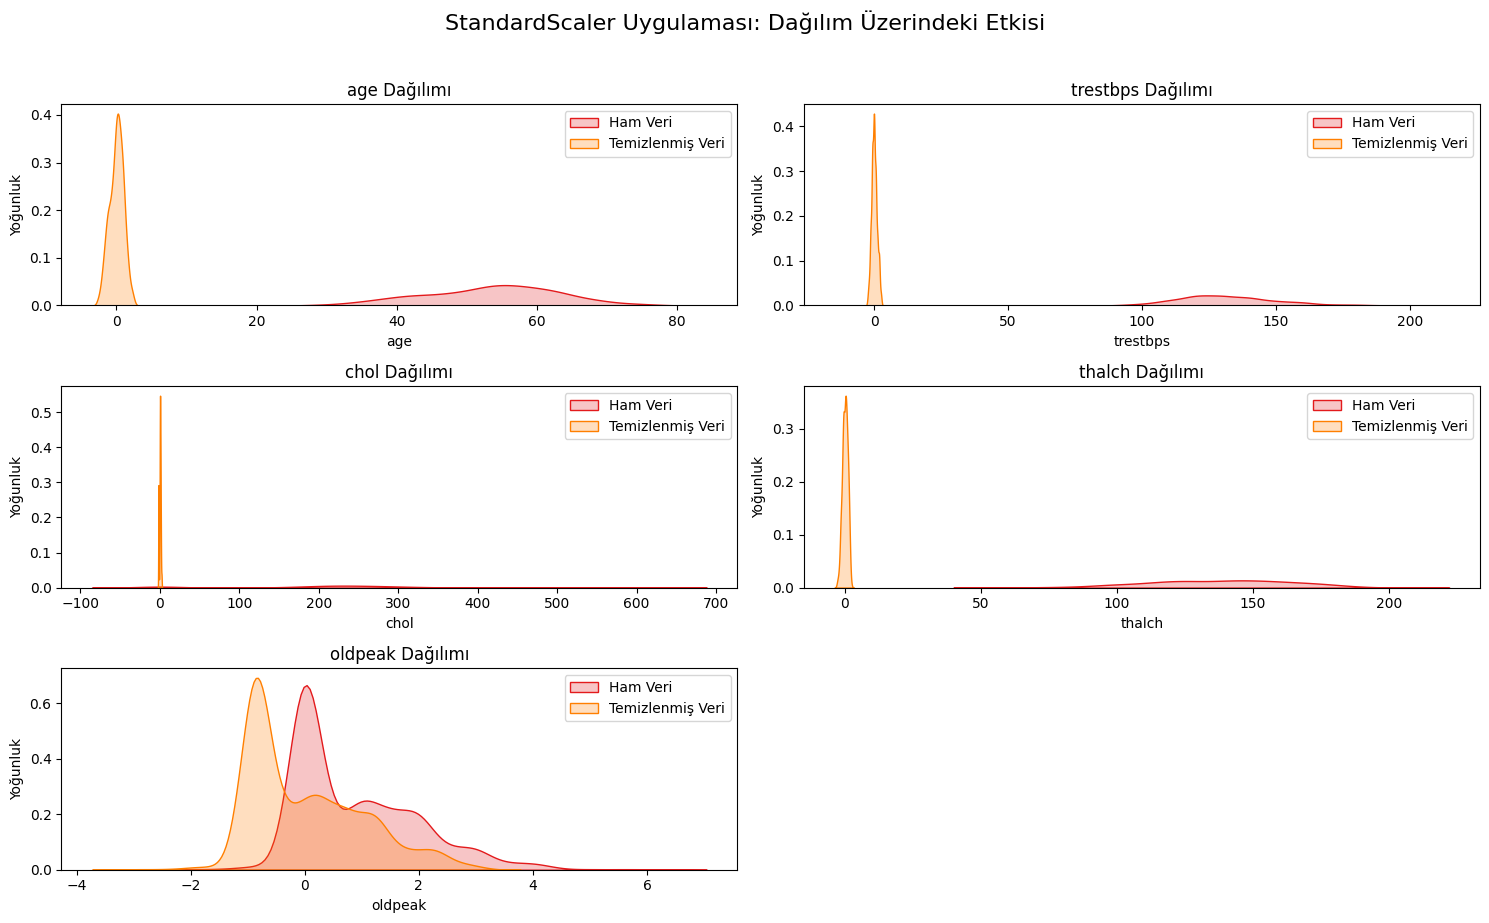

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 9))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(df[col].dropna(), ax=axes[i], fill=True, label="Ham Veri", color="#e31a1c")
    sns.kdeplot(df_encoded[col].dropna(), ax=axes[i], fill=True, label="Temizlenmi≈ü Veri", color="#ff7f00")
    axes[i].set_title(f"{col} Daƒüƒ±lƒ±mƒ±")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Yoƒüunluk")
    axes[i].legend()

# Eƒüer 6. subplot bo≈ü kalƒ±yorsa sil
if len(num_cols) < len(axes):
    for j in range(len(num_cols), len(axes)):
        fig.delaxes(axes[j])


plt.suptitle("StandardScaler Uygulamasƒ±: Daƒüƒ±lƒ±m √úzerindeki Etkisi", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

* √ñl√ßekleme sonrasƒ± veriler **ortalama ‚âà 0** ve **standart sapma ‚âà 1** olacak ≈üekilde yeniden merkezlenmi≈ütir.
* √ñzellikle `chol`, `thalch` ve `trestbps` gibi deƒüi≈ükenlerin daƒüƒ±lƒ±mƒ± ham h√¢lde √ßok geni≈ü aralƒ±klara yayƒ±lmƒ±≈üken, temizlenmi≈ü veride bu daƒüƒ±lƒ±m standart bir forma oturmu≈ütur.
* `oldpeak` deƒüi≈ükeninde bile daƒüƒ±lƒ±m sƒ±kƒ±la≈üarak modele daha uygun hale gelmi≈ütir.

> Bu kar≈üƒ±la≈ütƒ±rma, **veri standardizasyonunun sadece matematiksel deƒüil, daƒüƒ±lƒ±msal olarak da etkili olduƒüunu** g√∂rsel olarak ortaya koymaktadƒ±r.

---

* Bu grafikte, sayƒ±sal deƒüi≈ükenlerin √∂l√ßekleme √∂ncesi ve sonrasƒ± daƒüƒ±lƒ±mƒ±nƒ± kar≈üƒ±la≈ütƒ±rdƒ±m. StandardScaler uygulamasƒ±yla birlikte veriler normalize edildiƒüi i√ßin artƒ±k her deƒüi≈ükenin ortalamasƒ± sƒ±fƒ±ra yakƒ±n, standart sapmasƒ± ise bire yakƒ±n hale geldi.
* Bu sayede model, farklƒ± b√ºy√ºkl√ºkteki sayƒ±sal deƒüerlerden etkilenmeden √∂ƒürenme yapabilecek.



### Fig√ºr: Target ile Korelasyonu Y√ºksek √ñzellikler

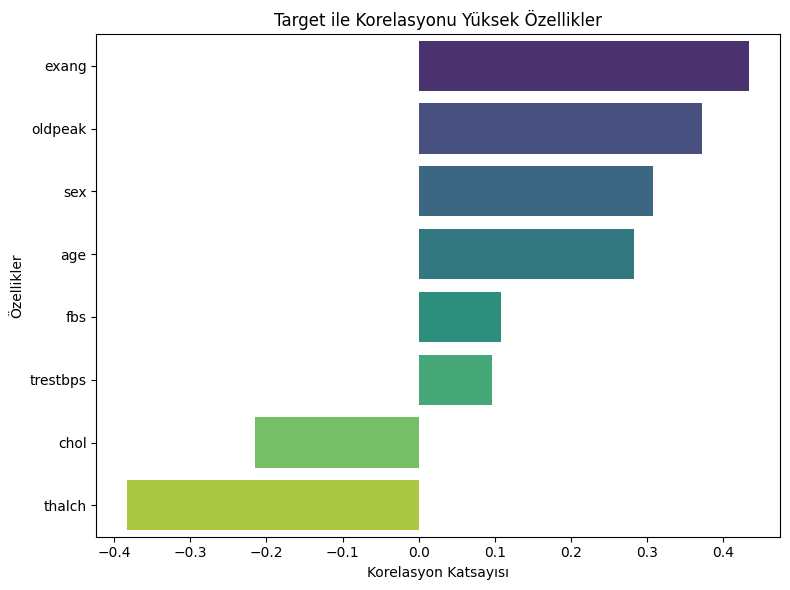

In [ ]:
numeric_df = df_encoded.select_dtypes(include='number')

# Korelasyon matrisini hesapla
corr_matrix = numeric_df.corr()

# Target ile olan korelasyonlarƒ± √ßek
target_corr = corr_matrix['target'].drop('target').sort_values(ascending=False)

# G√∂rselle≈ütir
plt.figure(figsize=(8, 6))
sns.barplot(x=target_corr.values, y=target_corr.index, palette='viridis')
plt.title('Target ile Korelasyonu Y√ºksek √ñzellikler')
plt.xlabel('Korelasyon Katsayƒ±sƒ±')
plt.ylabel('√ñzellikler')
plt.tight_layout()
plt.show()


##  Target ile Korelasyonu Y√ºksek √ñzellikler:

### En y√ºksek pozitif korelasyona sahip deƒüi≈ükenler:

1. **`exang` (Egzersize baƒülƒ± anjina):** **+0.45**

   * Egzersize baƒülƒ± anjina varsa (exang = 1), kalp hastalƒ±ƒüƒ± olma ihtimali artƒ±yor gibi g√∂z√ºk√ºyor.
2. **`oldpeak` (ST depresyonu):** **+0.4 civarƒ±**

   * ST depresyonu arttƒ±k√ßa hastalƒ±k olasƒ±lƒ±ƒüƒ± da artƒ±yor ‚Üí beklenen bir sonu√ß.
3. **`sex` (Cinsiyet):** Yakla≈üƒ±k **+0.3**

   * Erkeklerde kalp hastalƒ±ƒüƒ± riski daha y√ºksek olabilir
---

### üîπ Negatif korelasyonlar:

1. **`thalch` (Maksimum kalp atƒ±m hƒ±zƒ±):** **-0.4 civarƒ±**

   * Maksimum kalp atƒ±m hƒ±zƒ± y√ºksek olan bireylerde hastalƒ±k riski daha d√º≈ü√ºk olabilir. Bu da **saƒülƒ±klƒ± kalp fonksiyonlarƒ±**yla ili≈ükili olabilir.
2. **`chol` (Kolesterol):** **-0.2 civarƒ±**

   * Kolesterol d√ºzeyi arttƒ±k√ßa hastalƒ±k riski azalmƒ±≈ü g√∂r√ºn√ºyor, bu veride **nonlinear** ili≈üki veya **ba≈üka fakt√∂rlerle maskelenme** olabilir.

---

### N√∂tr veya d√º≈ü√ºk etkili deƒüi≈ükenler:

* **`fbs`, `trestbps`, `age`** gibi deƒüi≈ükenler korelasyon a√ßƒ±sƒ±ndan daha zayƒ±f (0.1 civarƒ±).

  * Ama bu √∂zelliklerin √∂nemini deƒüerlendirmek i√ßin mutlaka **feature importance** veya **SHAP** gibi y√∂ntemlere de bakmak gerekir.

---

* Veride **en g√º√ßl√º belirleyiciler** olarak `exang`, `oldpeak`, `thalch` √∂ne √ßƒ±kƒ±yor.


### Fig√ºr: Egzersize Baƒülƒ± Anjina (exang) ile Kalp Hastalƒ±ƒüƒ± ƒ∞li≈ükisi

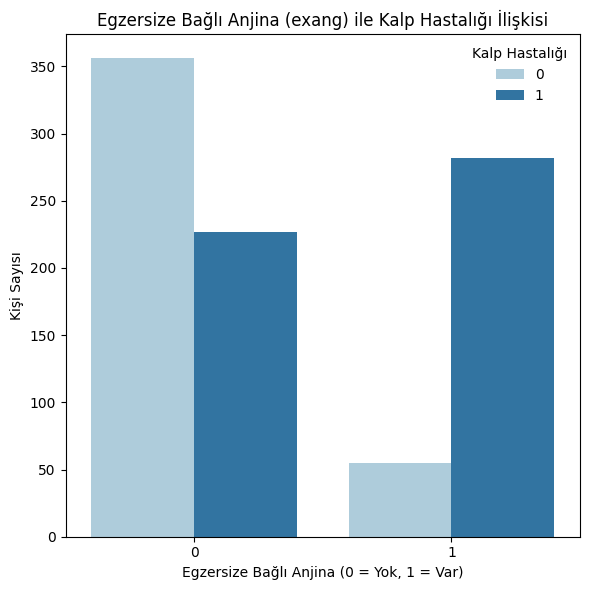

In [ ]:
plt.figure(figsize=(6, 6))
sns.countplot(data=df_encoded, x='exang', hue='target', palette='Paired')
plt.title("Egzersize Baƒülƒ± Anjina (exang) ile Kalp Hastalƒ±ƒüƒ± ƒ∞li≈ükisi")
plt.xlabel("Egzersize Baƒülƒ± Anjina (0 = Yok, 1 = Var)")
plt.ylabel("Ki≈üi Sayƒ±sƒ±")
plt.legend(title="Kalp Hastalƒ±ƒüƒ±", frameon=False)
plt.tight_layout()
plt.show()


exang = 1 (anjina var) olanlarda kalp hastalƒ±ƒüƒ± (target = 1) olasƒ±lƒ±ƒüƒ± ciddi ≈üekilde artƒ±yor.

exang = 0 (anjina yok) olanlarda ise daha √ßok hastalƒ±k yok (target = 0).

Egzersize baƒülƒ± g√∂ƒü√ºs aƒürƒ±sƒ± ya≈üayan bireylerde kalp hastalƒ±ƒüƒ± riski olduk√ßa artƒ±yor.

### Fig√ºr: ST Depresyonu (oldpeak) ile Kalp Hastalƒ±ƒüƒ± ƒ∞li≈ükisi

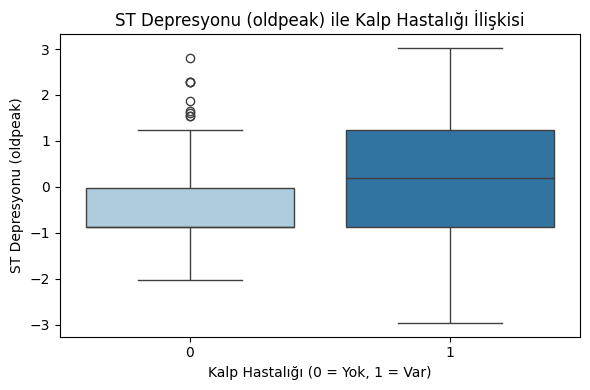

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_encoded, x='target', y='oldpeak', palette='Paired')
plt.title("ST Depresyonu (oldpeak) ile Kalp Hastalƒ±ƒüƒ± ƒ∞li≈ükisi")
plt.xlabel("Kalp Hastalƒ±ƒüƒ± (0 = Yok, 1 = Var)")
plt.ylabel("ST Depresyonu (oldpeak)")
plt.tight_layout()
plt.show()

Hastalƒ±k olmayan bireylerin oldpeak deƒüerleri √ßok d√º≈ü√ºk. Medyanlarƒ± yakla≈üƒ±k 0 civarƒ±nda.

Hastalƒ±k olan bireylerde oldpeak deƒüeri genelde daha y√ºksek ve daƒüƒ±lƒ±mƒ± daha geni≈ü.

ST depresyonu arttƒ±k√ßa kalp rahatsƒ±zlƒ±ƒüƒ± olasƒ±lƒ±ƒüƒ± da ciddi oranda artƒ±yor.

oldpeak, kalp hastalƒ±ƒüƒ± i√ßin olduk√ßa anlamlƒ± bir biyobelirte√ß. Medyan ve daƒüƒ±lƒ±m farkƒ± √ßok net.



### Fig√ºr: Maksimum Kalp Atƒ±≈ü Hƒ±zƒ± (thalch) ile Kalp Hastalƒ±ƒüƒ± ƒ∞li≈ükisi

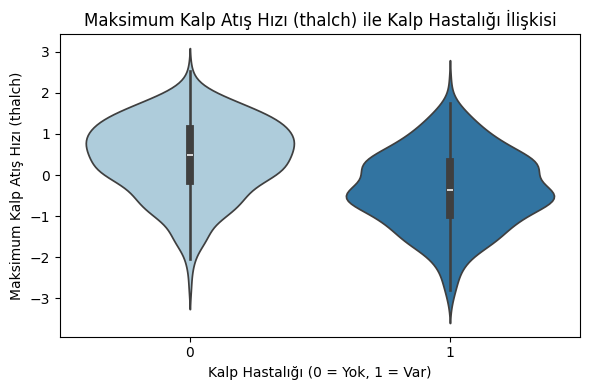

In [ ]:
plt.figure(figsize=(6, 4))
sns.violinplot(data=df_encoded, x='target', y='thalch', palette='Paired')
plt.title("Maksimum Kalp Atƒ±≈ü Hƒ±zƒ± (thalch) ile Kalp Hastalƒ±ƒüƒ± ƒ∞li≈ükisi")
plt.xlabel("Kalp Hastalƒ±ƒüƒ± (0 = Yok, 1 = Var)")
plt.ylabel("Maksimum Kalp Atƒ±≈ü Hƒ±zƒ± (thalch)")
plt.tight_layout()
plt.show()


Kalp hastalƒ±ƒüƒ± olmayan bireylerde (0) thalch deƒüeri genellikle daha y√ºksek ‚Üí kalp fonksiyonu daha g√º√ßl√º.

Kalp hastalƒ±ƒüƒ± olan bireylerde (1) daƒüƒ±lƒ±m a≈üaƒüƒ±ya doƒüru kaymƒ±≈ü, medyan daha d√º≈ü√ºk.

Daƒüƒ±lƒ±m ≈üekilleri arasƒ±ndaki fark, hastalƒ±k ile thalch arasƒ±nda g√º√ßl√º negatif bir ili≈üki olduƒüunu ortaya koyuyor.

Y√ºksek kalp atƒ±m hƒ±zƒ± genellikle daha saƒülƒ±klƒ± bir kalbi i≈üaret ediyor olabilir. Bu deƒüi≈ükenin de ROC analizde √ßok y√ºksek AUC vermesi beklenir.

### Fig√ºr: Kalp Hastalƒ±ƒüƒ± ve Cinsiyet


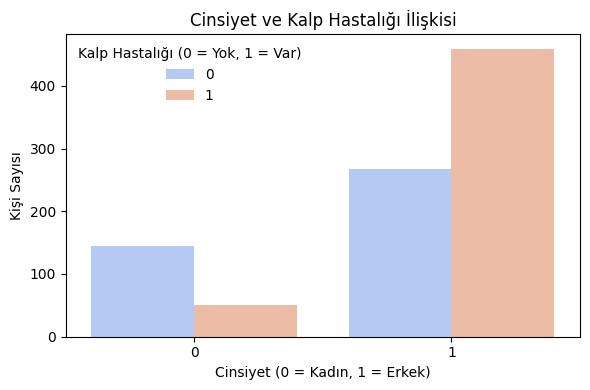

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_encoded, x='sex', hue='target', palette='coolwarm')
plt.title("Cinsiyet ve Kalp Hastalƒ±ƒüƒ± ƒ∞li≈ükisi")
plt.xlabel("Cinsiyet (0 = Kadƒ±n, 1 = Erkek)")
plt.ylabel("Ki≈üi Sayƒ±sƒ±")
plt.legend(title="Kalp Hastalƒ±ƒüƒ± (0 = Yok, 1 = Var)", frameon= False)
plt.tight_layout()
plt.show()


sex = 1 olanlarda (erkekler):

Kalp hastalƒ±ƒüƒ± (target = 1) sayƒ±sƒ± genelde daha y√ºksek √ßƒ±kar.

sex = 0 olanlarda (kadƒ±nlar):

Kalp hastalƒ±ƒüƒ± riski daha d√º≈ü√ºk g√∂r√ºnebilir.

### Fig√ºr: Ya≈ü ve Kalp Krizi

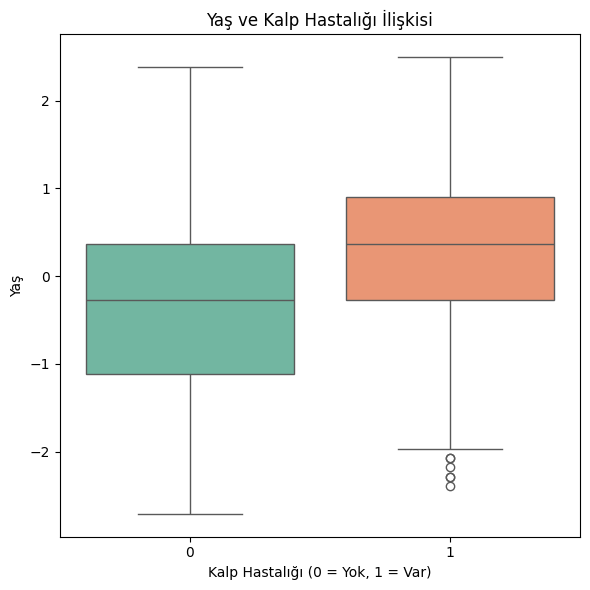

In [ ]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=df_encoded, x='target', y='age', palette='Set2')
plt.title("Ya≈ü ve Kalp Hastalƒ±ƒüƒ± ƒ∞li≈ükisi")
plt.xlabel("Kalp Hastalƒ±ƒüƒ± (0 = Yok, 1 = Var)")
plt.ylabel("Ya≈ü")
plt.tight_layout()
plt.show()


Ya≈ü arttƒ±k√ßa kalp hastalƒ±ƒüƒ± riski artƒ±yor diyebiliriz.
Ancak ya≈ü tek ba≈üƒ±na yeterli deƒüil ‚Äî √∂zellikle gen√ß ya≈üta hastalƒ±k ya≈üayan bireyler de var, bu da √ßok deƒüi≈ükenli modelleme ihtiyacƒ±nƒ± g√∂steriyor.


In [ ]:
# Ya≈ü gruplarƒ±na ayƒ±rma
df_cleaned['age_group'] = pd.cut(
    df_cleaned['age'],
    bins=[25, 40, 50, 60, 70, 80],
    labels=['25-40', '41-50', '51-60', '61-70', '71-80'],
    right=False
)

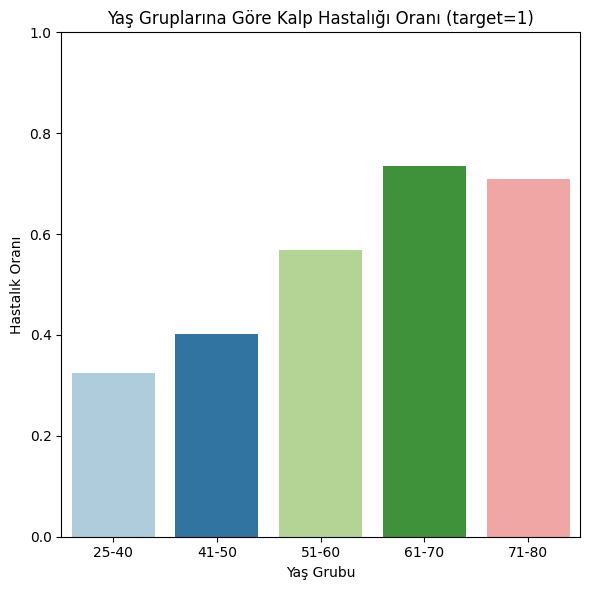

In [ ]:
age_group_stats = df_cleaned.groupby('age_group')['target'].mean().reset_index()

plt.figure(figsize=(6, 6))
sns.barplot(data=age_group_stats, x='age_group', y='target', palette='Paired')
plt.title('Ya≈ü Gruplarƒ±na G√∂re Kalp Hastalƒ±ƒüƒ± Oranƒ± (target=1)')
plt.ylabel('Hastalƒ±k Oranƒ±')
plt.xlabel('Ya≈ü Grubu')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


Ya≈ü ilerledik√ße kalp hastalƒ±ƒüƒ± oranƒ± dikkat √ßekici ≈üekilde artmaktadƒ±r.
√ñzellikle 61-70 ya≈ü grubunda bu oran %73'e kadar √ßƒ±kmakta, 51 ya≈ü √ºst√º bireylerde genel eƒüilim yukarƒ± y√∂nl√ºd√ºr. Bu bulgu klinik a√ßƒ±dan da beklenen bir durumdur √ß√ºnk√º ya≈ü, kardiyovask√ºler hastalƒ±klar i√ßin en g√º√ßl√º risk fakt√∂rlerinden biridir.

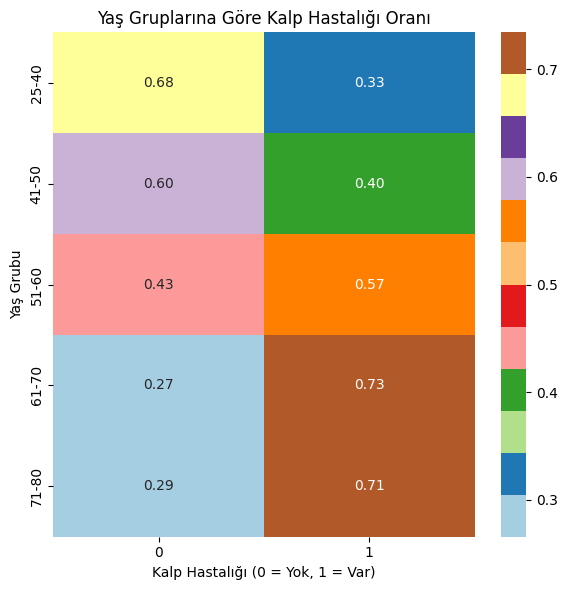

In [ ]:
# Her ya≈ü grubunun kalp hastalƒ±ƒüƒ±na sahip olup olmama oranlarƒ±nƒ± g√∂steren oran tablosu
age_group_rate = pd.crosstab(df_cleaned['age_group'], df_cleaned['target'], normalize='index')

plt.figure(figsize=(6, 6))
sns.heatmap(age_group_rate, annot=True, cmap='Paired', fmt='.2f')
plt.title("Ya≈ü Gruplarƒ±na G√∂re Kalp Hastalƒ±ƒüƒ± Oranƒ±")
plt.xlabel("Kalp Hastalƒ±ƒüƒ± (0 = Yok, 1 = Var)")
plt.ylabel("Ya≈ü Grubu")
plt.tight_layout()
plt.show()



| Ya≈ü Grubu | Kalp Hastalƒ±ƒüƒ± Yok (%) | Kalp Hastalƒ±ƒüƒ± Var (%) | Yorum                                                |
| --------- | ---------------------- | ---------------------- | ---------------------------------------------------- |
| 25‚Äì40     | %68                    | %32                    | Gen√ßlerde hastalƒ±k oranƒ± d√º≈ü√ºk. Koruyucu etki g√º√ßl√º. |
| 41‚Äì50     | %60                    | %40                    | Risk artmaya ba≈ülƒ±yor.                               |
| 51‚Äì60     | %43                    | %57                    | E≈üik ya≈ü grubu ‚Üí **riskli b√∂lge**ye giriliyor.       |
| 61‚Äì70     | %27                    | %73                    | **En riskli ya≈ü grubu**, hastalƒ±k oranƒ± zirvede.     |
| 71‚Äì80     | %29                    | %71                    | Risk h√¢l√¢ √ßok y√ºksek ama artƒ±≈ü yava≈ülamƒ±≈ü.           |


---


* **Ya≈ü arttƒ±k√ßa kalp hastalƒ±ƒüƒ± riski belirgin ≈üekilde artmaktadƒ±r.**
* √ñzellikle **50 ya≈ü sonrasƒ±** bireylerde durum dramatik ≈üekilde deƒüi≈ümektedir:

  * Saƒülƒ±klƒ± birey oranƒ± azalƒ±rken, hastalƒ±k oranƒ± artƒ±yor.
  * **60 ya≈ü √ºst√º bireylerde** kalp hastalƒ±ƒüƒ± oranƒ± %70'in √ºzerine √ßƒ±kƒ±yor.
* Bu tablo, medikal literat√ºrle uyumludur: ya≈ü, kardiyovask√ºler risk fakt√∂rleri i√ßinde **en g√º√ßl√º belirleyicilerden biridir.**

---

* **25‚Äì40 ya≈ü arasƒ± bireylerde** kalp hastalƒ±ƒüƒ± oranƒ± %33 civarƒ±ndayken, saƒülƒ±klƒ± birey oranƒ± %68.
* **61‚Äì70 ve 71‚Äì80 ya≈ü gruplarƒ±nda** kalp hastalƒ±ƒüƒ± oranƒ± sƒ±rasƒ±yla %73 ve %71.
* Bu, ya≈üla birlikte **prevalansƒ±n hƒ±zla y√ºkseldiƒüini** ve modellemede ya≈ü deƒüi≈ükenine mutlaka √∂ncelik verilmesi gerektiƒüini g√∂stermektedir.


# **6. Modelleme**

In [ ]:

print("\n--- Train/Test Ayrƒ±mƒ± √ñNCESƒ∞ ---")
print(f"Veri seti ≈üekli: {df_encoded.shape}")

# √ñzellik ve hedef ayrƒ±mƒ±
X = df_encoded.drop("target", axis=1)
y = df_encoded["target"]

print("\n--- Train/Test Ayrƒ±mƒ± UYGULANIYOR ---")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Veri %80 eƒüitim, %20 test olarak ayrƒ±ldƒ±.")
print("\n--- Train/Test Ayrƒ±mƒ± SONRASI ---")
print(f"X_train ≈üekli: {X_train.shape}")
print(f"X_test ≈üekli:  {X_test.shape}")
print(
    f"y_train sƒ±nƒ±f daƒüƒ±lƒ±mƒ±:\n{y_train.value_counts(normalize=True).round(2)}"
)
print(f"y_test  sƒ±nƒ±f daƒüƒ±lƒ±mƒ±:\n{y_test.value_counts(normalize=True).round(2)}")




--- Train/Test Ayrƒ±mƒ± √ñNCESƒ∞ ---
Veri seti ≈üekli: (920, 19)

--- Train/Test Ayrƒ±mƒ± UYGULANIYOR ---
Veri %80 eƒüitim, %20 test olarak ayrƒ±ldƒ±.

--- Train/Test Ayrƒ±mƒ± SONRASI ---
X_train ≈üekli: (736, 18)
X_test ≈üekli:  (184, 18)
y_train sƒ±nƒ±f daƒüƒ±lƒ±mƒ±:
target
1    0.55
0    0.45
Name: proportion, dtype: float64
y_test  sƒ±nƒ±f daƒüƒ±lƒ±mƒ±:
target
1    0.55
0    0.45
Name: proportion, dtype: float64


**Medikal Modelleme Metrikleri***

**Recall (Duyarlƒ±lƒ±k / True Positive Rate)**
- **Tanƒ±m:** Ger√ßek hasta olan bireylerin ne kadarƒ±nƒ±n doƒüru tespit edildiƒüini g√∂sterir.
- **√ñnemi:** Kalp hastalƒ±ƒüƒ± gibi ciddi rahatsƒ±zlƒ±klarda, hastalƒ±ƒüƒ± olan bir ki≈üiyi saƒülƒ±klƒ± olarak sƒ±nƒ±flandƒ±rmak (False Negative) hayati riskler ta≈üƒ±yabilir. Bu nedenle, *recall* medikal projelerde **birincil √∂nceliƒüe** sahiptir.

**Precision (Kesinlik)**
- **Tanƒ±m:** Modelin hasta dediƒüi bireylerin ger√ßekten hasta olma oranƒ±dƒ±r.
- **√ñnemi:** Yanlƒ±≈ü alarm sayƒ±sƒ±nƒ± azaltmak (False Positive), gereksiz test ve maliyetleri √∂nlemek i√ßin √∂nemlidir. Ancak, recall kadar kritik deƒüildir.

**F1-Score**
- **Tanƒ±m:** Precision ve Recall dengesini √∂l√ßen harmonik ortalamadƒ±r.
- **√ñnemi:** √ñzellikle sƒ±nƒ±f daƒüƒ±lƒ±mƒ± dengesiz olan durumlarda modelin genel ba≈üarƒ±sƒ±nƒ± √∂zetlemek i√ßin idealdir.

**ROC-AUC**
- **Tanƒ±m:** Modelin pozitif ve negatif sƒ±nƒ±flarƒ± ayƒ±rt etme yeteneƒüini √∂l√ßer.
- **√ñnemi:** T√ºm sƒ±nƒ±flandƒ±rma e≈üiklerini g√∂z √∂n√ºne alarak genel performansƒ± deƒüerlendirmeye yarar. AUC deƒüeri 1'e yakla≈ütƒ±k√ßa modelin g√ºvenilirliƒüi artar.

> **√ñzetle:** Bu projede hedeflenen ≈üey, kalp hastalƒ±ƒüƒ± olan bireyleri ka√ßƒ±rmamak olduƒüu i√ßin **recall** √∂n planda tutulmalƒ±; fakat precision, F1-score ve ROC-AUC deƒüerleriyle birlikte dengeli bir deƒüerlendirme yapƒ±lmalƒ±dƒ±r.


In [ ]:
# T√ºm modelleri tanƒ±mla
model_list = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(
        use_label_encoder=False, eval_metric="logloss", random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
}



--- Logistic Regression Modeli Eƒüitiliyor ve Deƒüerlendiriliyor ---


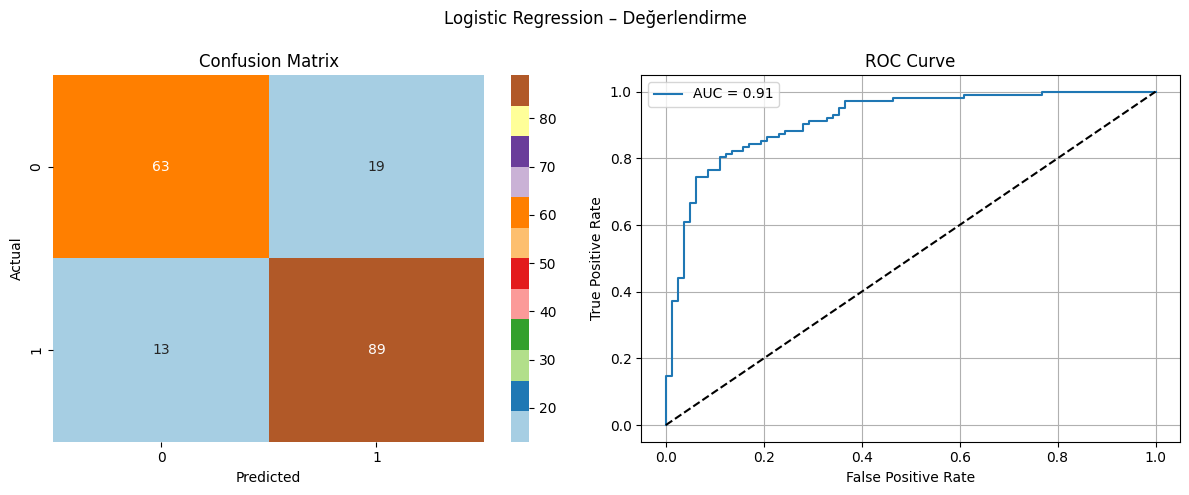


--- Random Forest Modeli Eƒüitiliyor ve Deƒüerlendiriliyor ---


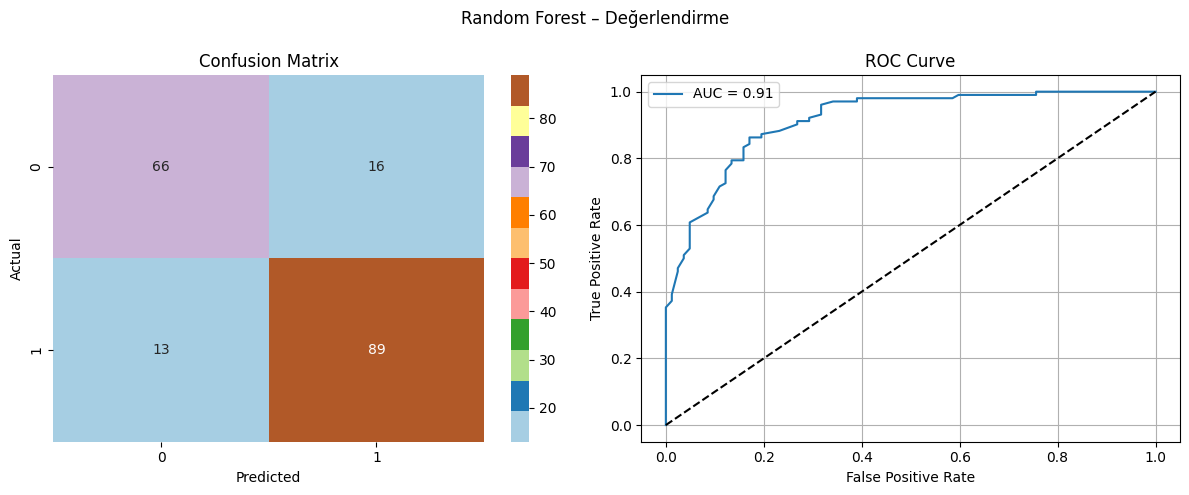


--- KNN Modeli Eƒüitiliyor ve Deƒüerlendiriliyor ---


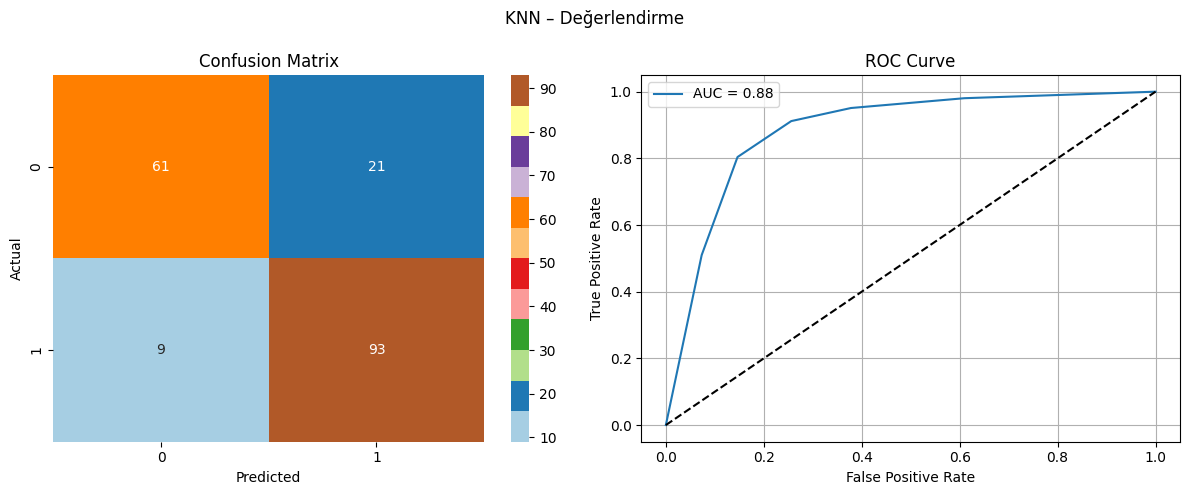


--- SVM Modeli Eƒüitiliyor ve Deƒüerlendiriliyor ---


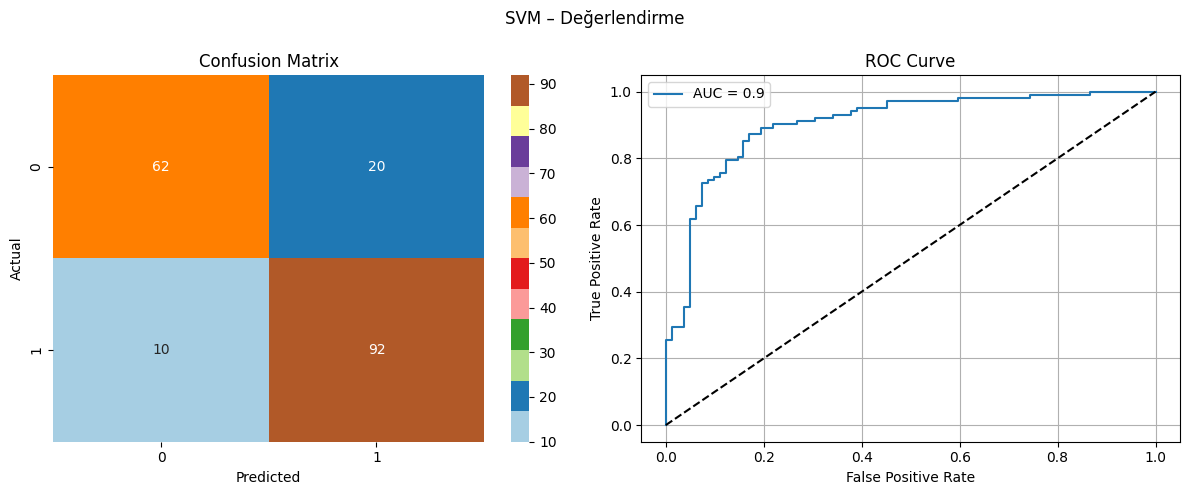


--- XGBoost Modeli Eƒüitiliyor ve Deƒüerlendiriliyor ---


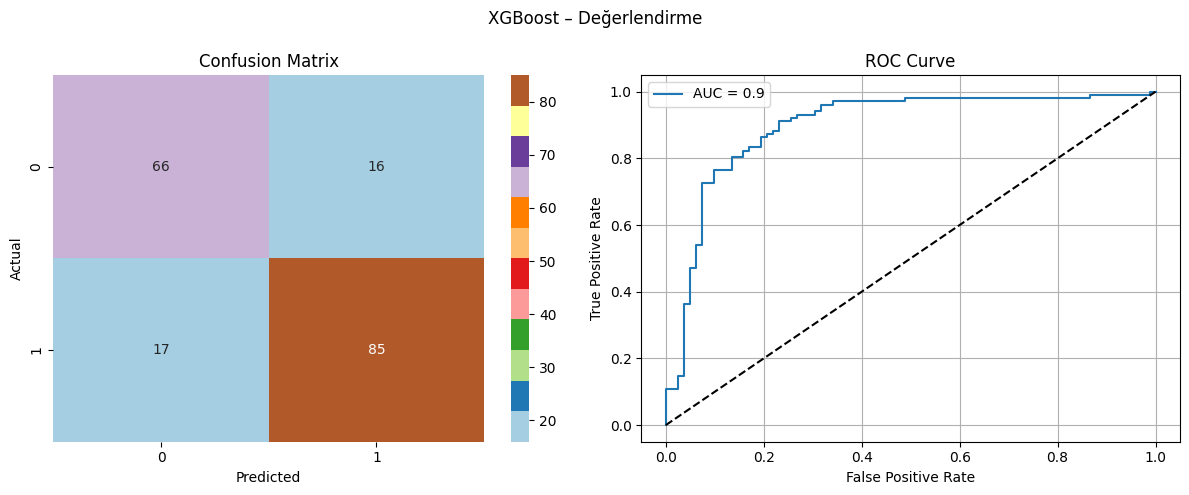


--- Gradient Boosting Modeli Eƒüitiliyor ve Deƒüerlendiriliyor ---


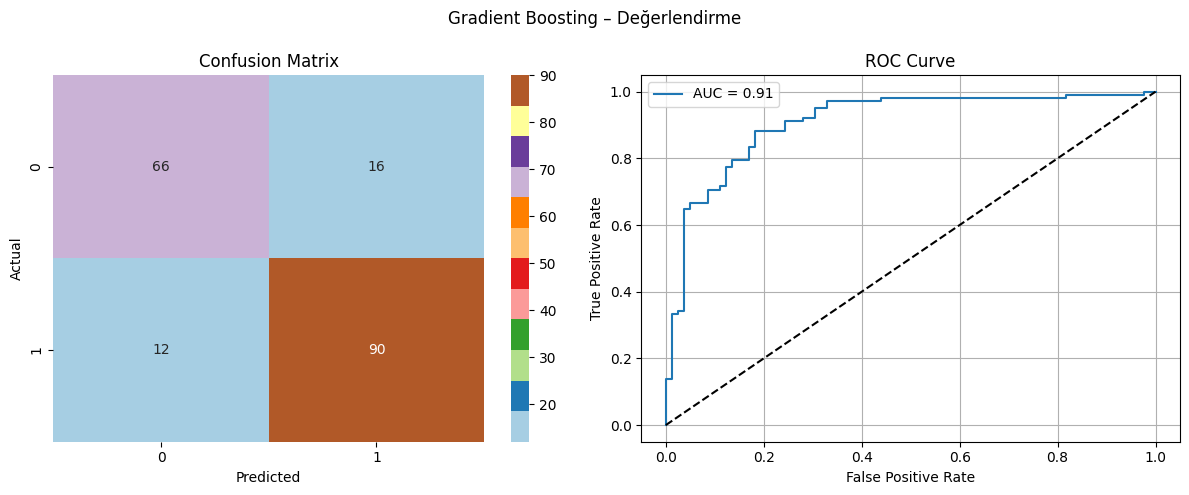


--- CatBoost Modeli Eƒüitiliyor ve Deƒüerlendiriliyor ---


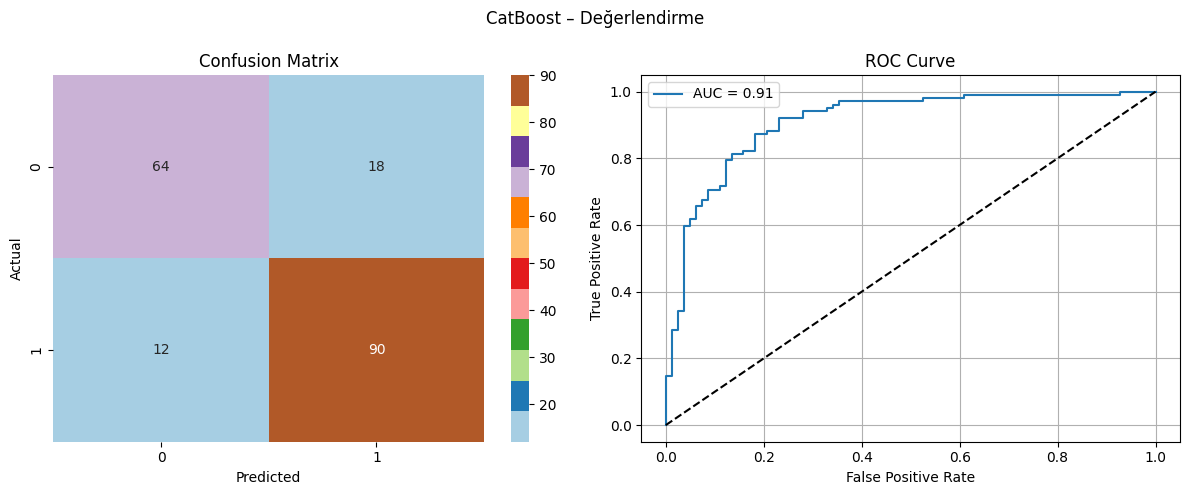

In [ ]:
# Sonu√ßlarƒ± ve g√∂rselleri tutmak i√ßin
all_model_metrics = {}

for name, model in model_list.items():
    print(f"\n--- {name} Modeli Eƒüitiliyor ve Deƒüerlendiriliyor ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = (
        model.predict_proba(X_test)[:, 1]
        if hasattr(model, "predict_proba")
        else None
    )

    acc = round(accuracy_score(y_test, y_pred), 2)
    prec = round(precision_score(y_test, y_pred), 2)
    rec = round(recall_score(y_test, y_pred), 2)
    f1 = round(f1_score(y_test, y_pred), 2)
    auc = round(roc_auc_score(y_test, y_prob), 2) if y_prob is not None else "N/A"

    all_model_metrics[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "ROC-AUC": auc,
    }
    # Subplot: Confusion Matrix ve ROC
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"{name} ‚Äì Deƒüerlendirme")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Paired", ax=axs[0])
    axs[0].set_title("Confusion Matrix")
    axs[0].set_xlabel("Predicted")
    axs[0].set_ylabel("Actual")

    # ROC Curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        axs[1].plot(fpr, tpr, label=f"AUC = {auc}")
        axs[1].plot([0, 1], [0, 1], "k--")
        axs[1].set_title("ROC Curve")
        axs[1].set_xlabel("False Positive Rate")
        axs[1].set_ylabel("True Positive Rate")
        axs[1].legend()
        axs[1].grid(True)
    else:
        axs[1].text(0.3, 0.5, "ROC Curve\nkullanƒ±lamaz", fontsize=14)
        axs[1].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


### Fig√ºr: Confusion Matrix ve ROC Eƒürisi G√∂rselle≈ütirme

In [ ]:
print("\n--- T√ºm Modellerin Metrikleri ---")
print(pd.DataFrame(all_model_metrics).T)


--- T√ºm Modellerin Metrikleri ---
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression      0.83       0.82    0.87      0.85     0.91
Random Forest            0.84       0.85    0.87      0.86     0.91
KNN                      0.84       0.82    0.91      0.86     0.88
SVM                      0.84       0.82    0.90      0.86     0.90
XGBoost                  0.82       0.84    0.83      0.84     0.90
Gradient Boosting        0.85       0.85    0.88      0.87     0.91
CatBoost                 0.84       0.83    0.88      0.86     0.91


In [ ]:
accuracies = {name: metrics["Accuracy"] for name, metrics in all_model_metrics.items()}
best_model_name = max(accuracies, key=accuracies.get)
best_model = model_list[best_model_name]
print(f"\n En iyi performans g√∂steren model: {best_model_name}")


 En iyi performans g√∂steren model: Gradient Boosting


### Fig√ºr: Model Doƒüruluk Kar≈üƒ±la≈ütƒ±rmasƒ±

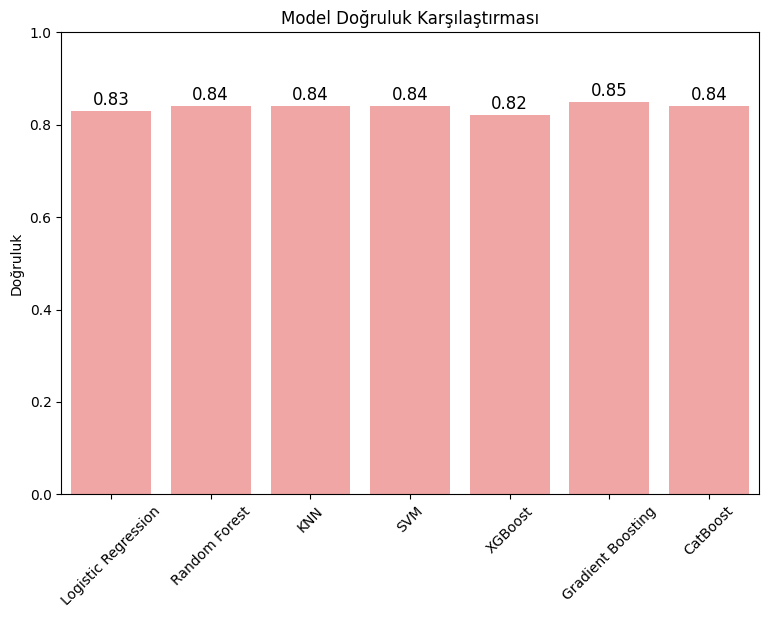

In [ ]:
fig, ax= plt.subplots(figsize=(9, 6))

sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), ax=ax, color=paired_colors[4])
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                (bar.get_x() + bar.get_width() / 2,
                 bar.get_height()), ha='center', va='center',
                size=12, xytext=(0, 8),
                textcoords='offset points')
plt.title('Model Doƒüruluk Kar≈üƒ±la≈ütƒ±rmasƒ±')
plt.xticks(rotation=45)
plt.ylabel('Doƒüruluk')
plt.ylim(0, 1.0)
plt.show()

* **Accuracy** ve **F1-Score** a√ßƒ±sƒ±ndan en y√ºksek ba≈üarƒ±yƒ± Gradient Boosting saƒülamƒ±≈ütƒ±r.
* ROC-AUC deƒüeri de olduk√ßa y√ºksek (0.91), bu da modelin pozitif sƒ±nƒ±fƒ± iyi ayƒ±rt ettiƒüini g√∂steriyor.
* **Recall deƒüeri (0.88)** en y√ºksek olduƒüu i√ßin, kalp hastalƒ±ƒüƒ± olan bireyleri tespit etmede daha ba≈üarƒ±lƒ±.

In [ ]:
for name, model in model_list.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{name}: Mean Accuracy = {scores.mean():.2f}")

Logistic Regression: Mean Accuracy = 0.77
Random Forest: Mean Accuracy = 0.72
KNN: Mean Accuracy = 0.72
SVM: Mean Accuracy = 0.74
XGBoost: Mean Accuracy = 0.69
Gradient Boosting: Mean Accuracy = 0.66
CatBoost: Mean Accuracy = 0.71


Model performanslarƒ±nƒ± daha g√ºvenilir ve veri baƒüƒ±mlƒ±lƒ±ƒüƒ±ndan baƒüƒ±msƒ±z deƒüerlendirebilmek i√ßin 5-Fold veya benzeri √ßapraz doƒürulama y√∂ntemleri uygulanmƒ±≈ütƒ±r.

* **Logistic Regression**, √ßapraz doƒürulama sƒ±rasƒ±nda en stabil ve genellenebilir performansƒ± g√∂stermi≈ütir.
* **SVM** ve **Random Forest** yakƒ±n skorlarla ikinci sƒ±rayƒ± payla≈ümaktadƒ±r.
* **Boosting tabanlƒ± modeller (XGBoost, Gradient Boosting, CatBoost)** daha d√º≈ü√ºk ortalama doƒüruluk g√∂stermi≈ütir. Bu durum, bu modellerin overfitting'e daha yatkƒ±n olabileceƒüini veya veri boyutu/model karma≈üƒ±klƒ±ƒüƒ±na g√∂re ayarlarƒ±nƒ±n yeterli olmadƒ±ƒüƒ±nƒ± g√∂sterebilir.
* Bu sonu√ßlar, eƒüitim/test seti √ºzerinde elde edilen ba≈üarƒ± skorlarƒ±yla birlikte deƒüerlendirilerek model se√ßimi yapƒ±lmalƒ±dƒ±r.

> √ñzellikle medikal verilerde **genellenebilirlik** √ßok √∂nemlidir. Bu y√ºzden sadece test skorlarƒ± deƒüil, √ßapraz doƒürulama skorlarƒ± da dikkate alƒ±nmalƒ±dƒ±r.

### Fig√ºr: Model Kar≈üƒ±la≈ütƒ±rmasƒ± ‚Äì Ortalama Doƒüruluk (5-Fold CV)

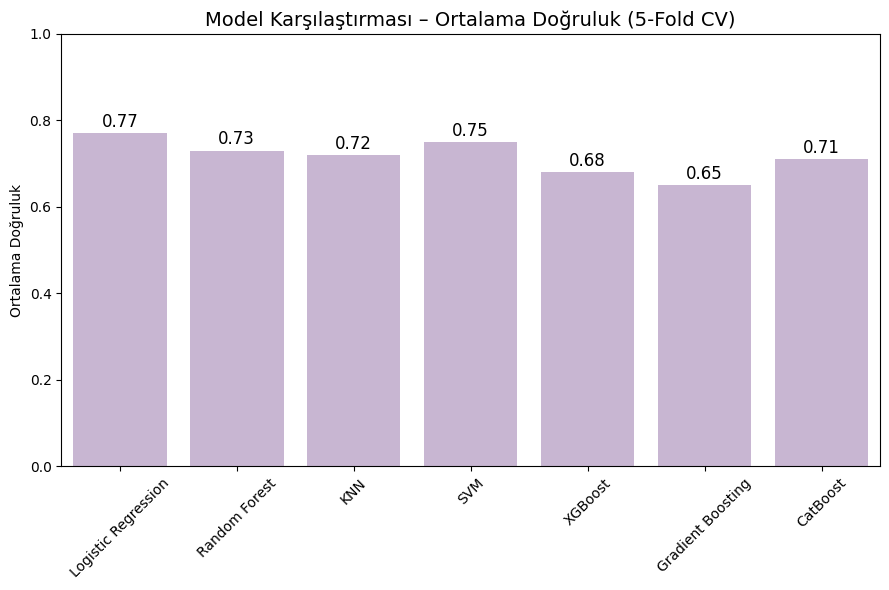

In [ ]:
# Cross-validation doƒüruluk skorlarƒ±
cv_scores = {
    "Logistic Regression": 0.77,
    "Random Forest": 0.73,
    "KNN": 0.72,
    "SVM": 0.75,
    "XGBoost": 0.68,
    "Gradient Boosting": 0.65,
    "CatBoost": 0.71
}


paired_colors = paired_palette.as_hex()

# Grafik
fig, ax = plt.subplots(figsize=(9, 6))

sns.barplot(
    x=list(cv_scores.keys()),
    y=list(cv_scores.values()),
    ax=ax,
    color=paired_colors[8]  # istediƒüin rengi buradan deƒüi≈ütirebilirsin
)

for bar in ax.patches:
    ax.annotate(
        format(bar.get_height(), '.2f'),
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha='center', va='center',
        size=12, xytext=(0, 8),
        textcoords='offset points'
    )

plt.title('Model Kar≈üƒ±la≈ütƒ±rmasƒ± ‚Äì Ortalama Doƒüruluk (5-Fold CV)', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Ortalama Doƒüruluk')
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()


###  5-Fold Cross Validation Sonu√ßlarƒ± ve Yorumum

Yukarƒ±daki grafikte, modellerin 5 katlƒ± √ßapraz doƒürulama (5-Fold CV) ile elde ettikleri ortalama doƒüruluk (mean accuracy) deƒüerlerini kar≈üƒ±la≈ütƒ±rdƒ±m. Bu y√∂ntemi kullanmamƒ±n sebebi, modellerin yalnƒ±zca bir test seti √ºzerinde deƒüil, farklƒ± veri par√ßalarƒ±nda da ne kadar tutarlƒ± performans g√∂sterdiƒüini g√∂rmek istememdi.

Bu sonu√ßlardan ≈üu √ßƒ±karƒ±mƒ± yaptƒ±m:

- **Logistic Regression**, 0.77 ortalama doƒüruluk ile en istikrarlƒ± ve genellenebilir model oldu.
- **SVM (0.75)** ve **Random Forest (0.73)** da ona yakƒ±n ba≈üarƒ± g√∂sterdi.
- **Boosting tabanlƒ± modeller (XGBoost, Gradient Boosting, CatBoost)** ise test setinde y√ºksek performans g√∂stermelerine raƒümen, √ßapraz doƒürulama sonu√ßlarƒ±nda daha d√º≈ü√ºk kaldƒ±. Bu da bu modellerin veri setime g√∂re daha fazla parametre ayarƒ±na ihtiya√ß duyduƒüunu ya da overfitting eƒüilimi g√∂sterdiƒüini d√º≈ü√ºnd√ºrd√º.

Bu nedenle sadece test seti skoruna deƒüil, √ßapraz doƒürulama sonu√ßlarƒ±na da bakarak **modelin genellenebilirliƒüini deƒüerlendirmeyi √∂nemli buluyorum.**


In [ ]:
overfit_check = {}

for name, model in model_list.items():
    model.fit(X_train, y_train)

    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))

    overfit_check[name] = {
        'Train Accuracy': round(train_acc, 2),
        'Test Accuracy': round(test_acc, 2),
        'Fark': round(train_acc - test_acc, 2)
    }


overfit_df = pd.DataFrame(overfit_check).T.sort_values('Fark', ascending=False)
print(overfit_df)


                     Train Accuracy  Test Accuracy  Fark
XGBoost                        1.00           0.82  0.18
Random Forest                  1.00           0.84  0.16
CatBoost                       0.96           0.84  0.12
Gradient Boosting              0.92           0.85  0.07
SVM                            0.86           0.84  0.02
KNN                            0.85           0.84  0.01
Logistic Regression            0.83           0.83  0.00


### Fig√ºr: T√ºm Modellerde Eƒüitim/Test Doƒüruluklarƒ± (Overfitting Kontrol√º)

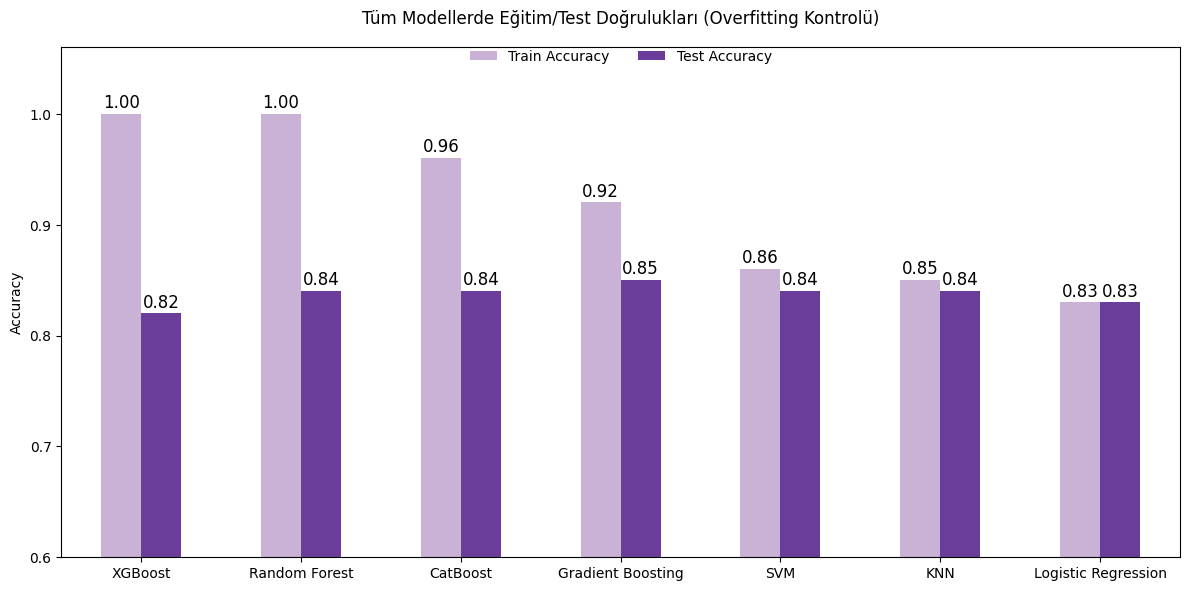

In [ ]:
ax = overfit_df[['Train Accuracy', 'Test Accuracy']].plot(
    kind='bar', figsize=(12,6), color=[paired_colors[8], paired_colors[9]]
)
plt.title('T√ºm Modellerde Eƒüitim/Test Doƒüruluklarƒ± (Overfitting Kontrol√º)', y=1.03)
plt.xticks(rotation=0)
plt.legend(frameon=False, ncol= 2, bbox_to_anchor=(0.5, 1.02), loc='upper center')
for bar in ax.patches:
    ax.annotate(f'{bar.get_height():.2f}',
                       (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                       ha='center', va='center',
                       size=12, xytext=(0, 8),
                       textcoords='offset points')
plt.ylabel('Accuracy')
plt.ylim(0.6, 1.06)
plt.tight_layout()
plt.show()

# Tuning Yapƒ±lmƒ±≈ü Modelleme

In [ ]:
### 1. Model ve Parametre Grid Tanƒ±mlamalarƒ± ###
models_params = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'n_estimators': [50, 100, 150],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            'n_neighbors': list(range(3, 11)),
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "solver": ["liblinear", "lbfgs"]
        }
    },
    "SVM": {
        "model": SVC(probability=True),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.01, 0.1],
            "max_depth": [3, 5]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric="logloss", use_label_encoder=False),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.01, 0.1],
            "max_depth": [3, 5]
        }
    },
    "CatBoost": {
        "model": CatBoostClassifier(verbose=0),
        "params": {
            "iterations": [100, 200],
            "learning_rate": [0.01, 0.1],
            "depth": [4, 6]
        }
    }
}


In [ ]:
### 2. GridSearchCV ile Model Tuning ve Sonu√ßlarƒ±n Kaydƒ± ###
results = []

for name, config in models_params.items():
    grid = GridSearchCV(config["model"], config["params"], cv=5, scoring='accuracy', n_jobs=-1)
    try:
        grid.fit(X_train, y_train)
        results.append({
            "Model": name,
            "Best Params": grid.best_params_,
            "Best Accuracy": round(grid.best_score_, 4)
        })
    except Exception as e:
        results.append({
            "Model": name,
            "Best Params": str(e),
            "Best Accuracy": "Error"
        })

tuning_results_df = pd.DataFrame(results)
print(tuning_results_df)


                 Model                                        Best Params  \
0        Random Forest  {'max_depth': 10, 'min_samples_leaf': 2, 'min_...   
1                  KNN  {'metric': 'manhattan', 'n_neighbors': 10, 'we...   
2  Logistic Regression                        {'C': 1, 'solver': 'lbfgs'}   
3                  SVM                      {'C': 10, 'kernel': 'linear'}   
4    Gradient Boosting  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
5              XGBoost  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
6             CatBoost  {'depth': 6, 'iterations': 200, 'learning_rate...   

   Best Accuracy  
0         0.8179  
1         0.8043  
2         0.8193  
3         0.8179  
4         0.8043  
5         0.8139  
6         0.8071  


### Fig√ºr: Confusion Matrix ve ROC Eƒürisi (Tuning sonrasƒ±)


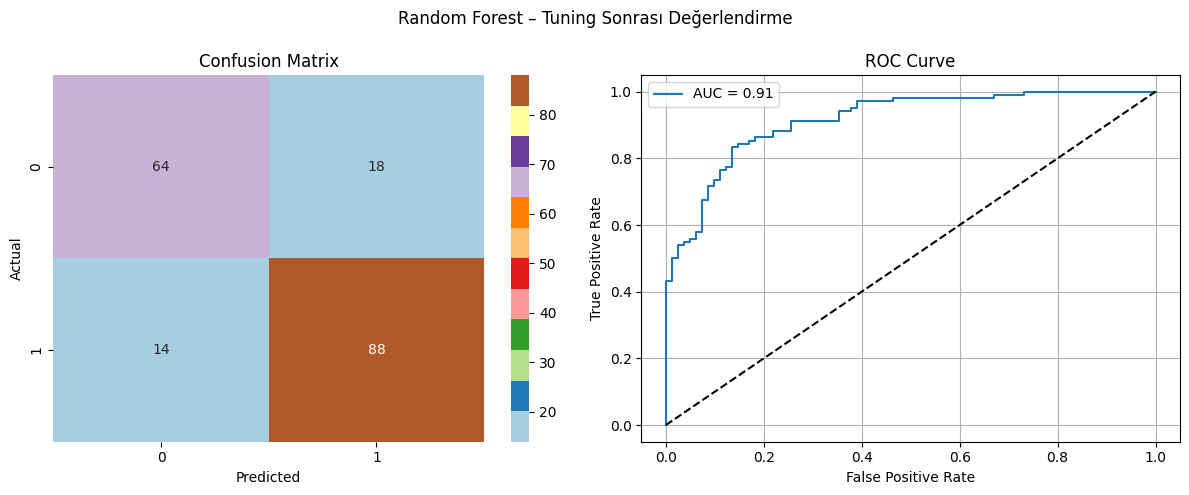

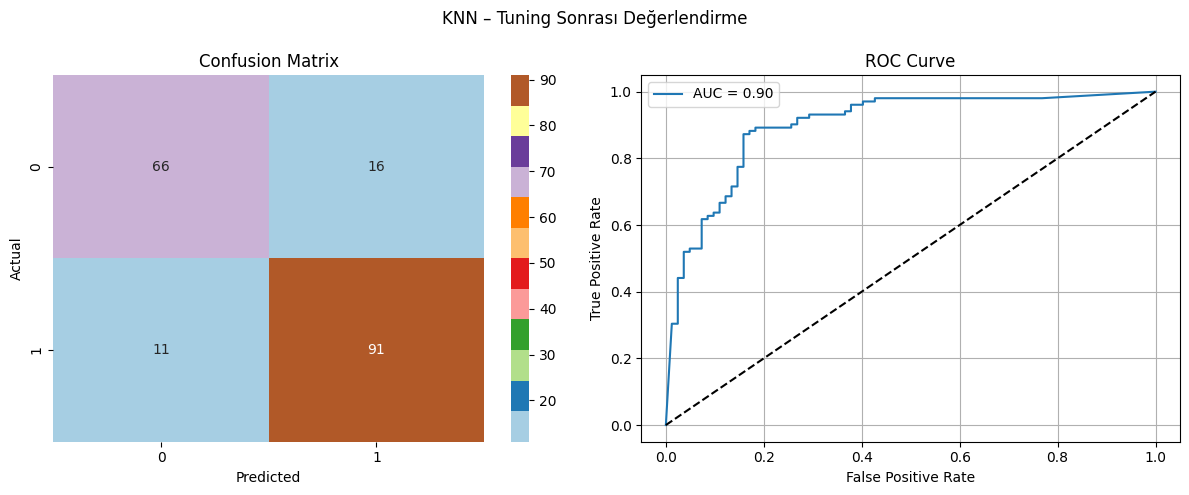

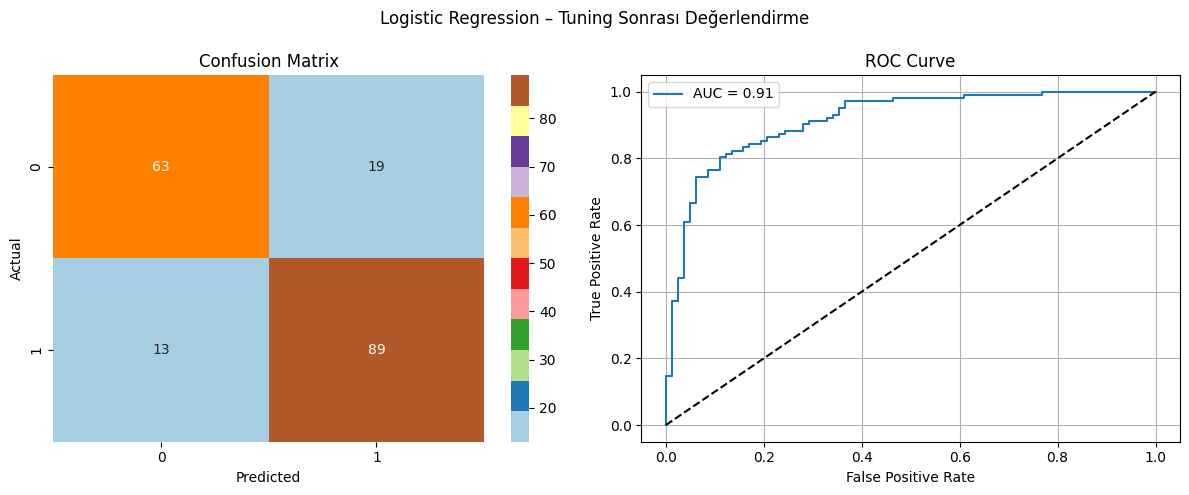

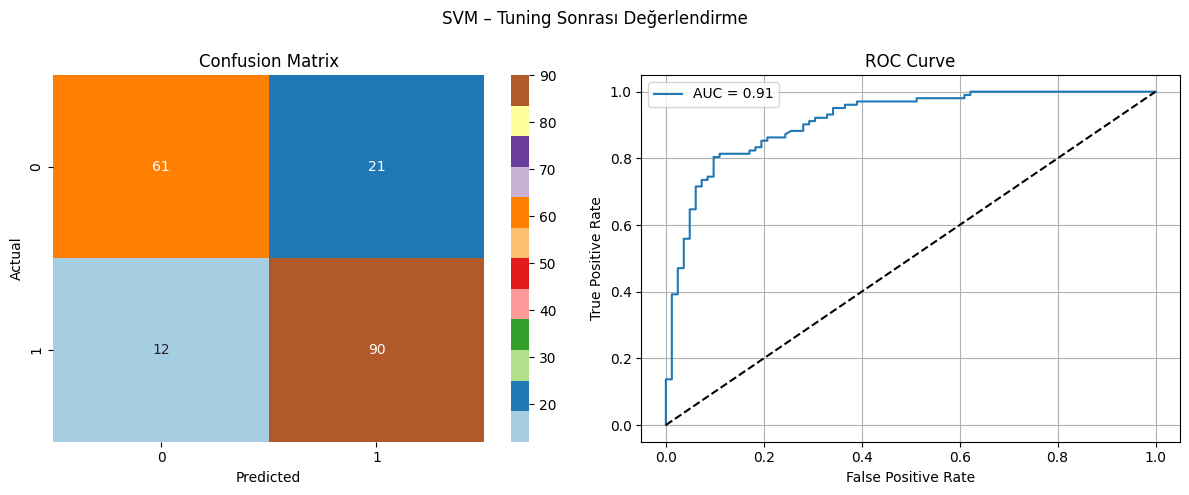

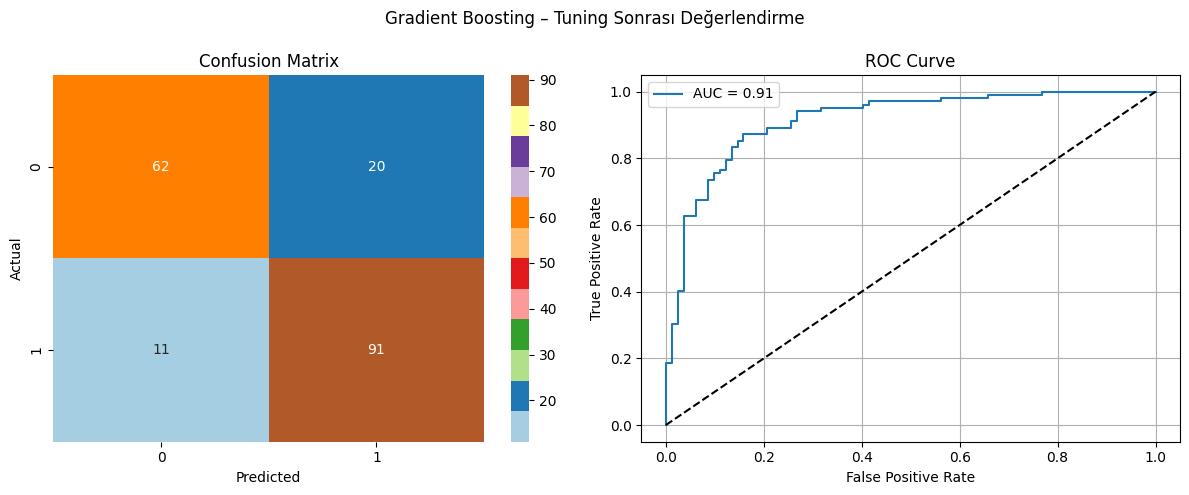

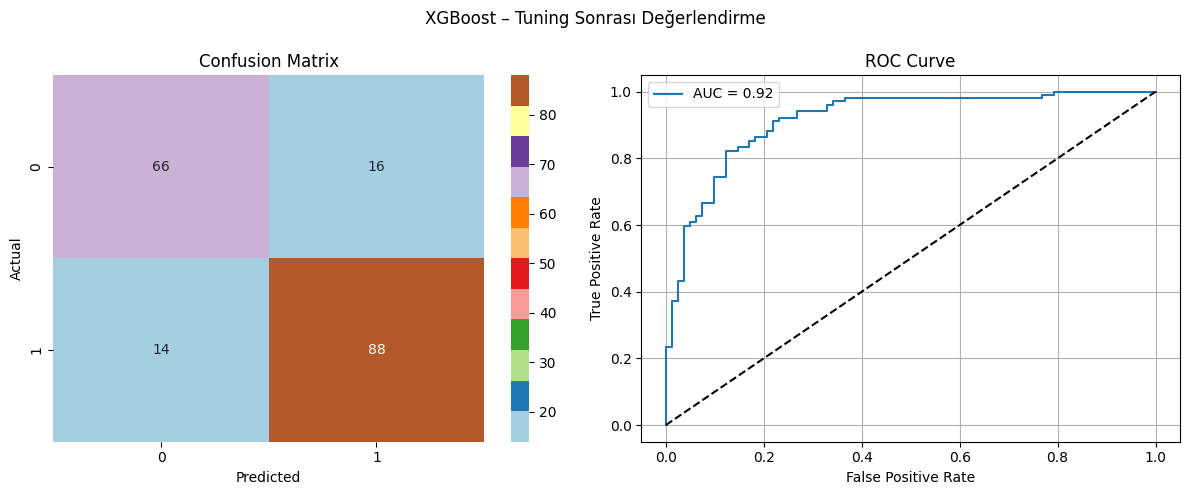

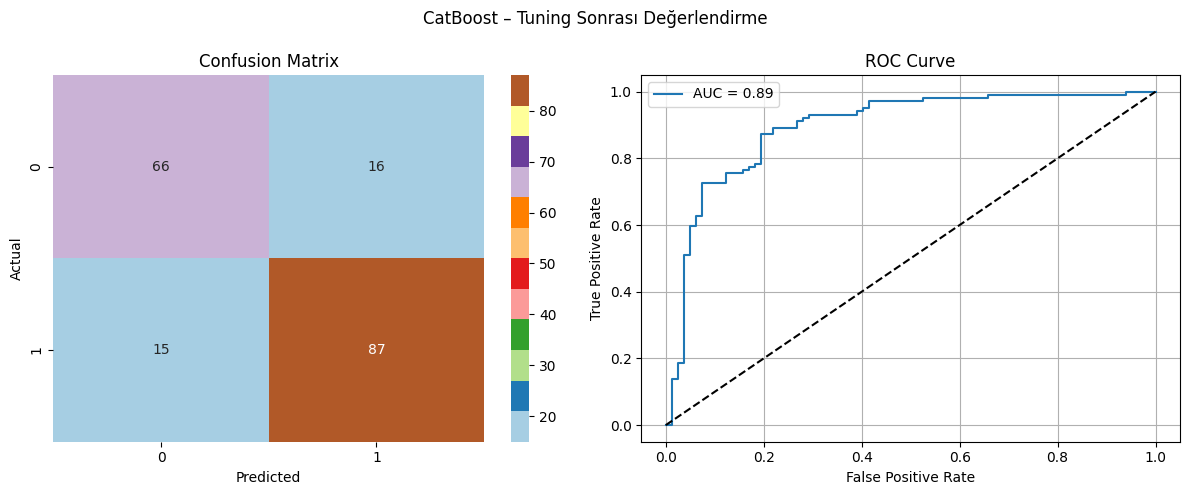


 Model Performans √ñzeti Tablosu:

              Model   AUC  False Negative  False Positive  Train Accuracy  Test Accuracy  Fark
      Random Forest 0.915              14              18           0.939          0.826 0.113
                KNN 0.899              11              16           1.000          0.853 0.147
Logistic Regression 0.914              13              19           0.830          0.826 0.004
                SVM 0.914              12              21           0.832          0.821 0.011
  Gradient Boosting 0.915              11              20           0.966          0.832 0.135
            XGBoost 0.916              14              16           0.927          0.837 0.090
           CatBoost 0.894              15              16           0.996          0.832 0.164


In [ ]:
# Sonu√ßlarƒ± saklayacaƒüƒ±mƒ±z liste
model_results = []

for index, row in tuning_results_df.iterrows():
    model_name = row['Model']
    best_params = row['Best Params']
    model_instance = models_params[model_name]['model']
    model_instance.set_params(**best_params)
    model_instance.fit(X_train, y_train)

    # Tahminler
    y_pred = model_instance.predict(X_test)
    y_prob = model_instance.predict_proba(X_test)[:, 1]
    y_train_pred = model_instance.predict(X_train)

    # Confusion Matrix ve metrikler
    cm = confusion_matrix(y_test, y_pred)
    fn = cm[1, 0]
    fp = cm[0, 1]
    auc = roc_auc_score(y_test, y_prob)
    test_acc = accuracy_score(y_test, y_pred)
    train_acc = accuracy_score(y_train, y_train_pred)
    fark = abs(train_acc - test_acc)

    # Sonu√ßlarƒ± listeye ekle
    model_results.append({
        "Model": model_name,
        "AUC": round(auc, 3),
        "False Negative": fn,
        "False Positive": fp,
        "Train Accuracy": round(train_acc, 3),
        "Test Accuracy": round(test_acc, 3),
        "Fark": round(fark, 3),

    })

    # Grafikler
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"{model_name} ‚Äì Tuning Sonrasƒ± Deƒüerlendirme")

    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Paired", ax=axs[0])
    axs[0].set_title("Confusion Matrix")
    axs[0].set_xlabel("Predicted")
    axs[0].set_ylabel("Actual")

    # ROC Curve
    axs[1].plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    axs[1].plot([0, 1], [0, 1], "k--")
    axs[1].set_title("ROC Curve")
    axs[1].set_xlabel("False Positive Rate")
    axs[1].set_ylabel("True Positive Rate")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Sonu√ß tablosunu DataFrame olarak g√∂ster
results_df = pd.DataFrame(model_results)
print("\n Model Performans √ñzeti Tablosu:\n")
print(results_df.to_string(index=False))


Bu √ßalƒ±≈ümada, kalp hastalƒ±ƒüƒ± riski ta≈üƒ±yan bireylerin sƒ±nƒ±flandƒ±rƒ±lmasƒ± i√ßin farklƒ± makine √∂ƒürenmesi modelleri kar≈üƒ±la≈ütƒ±rƒ±lmƒ±≈ütƒ±r. Model se√ßiminde yalnƒ±zca istatistiksel ba≈üarƒ± deƒüil, medikal a√ßƒ±dan hata t√ºrlerinin etkisi de g√∂z √∂n√ºnde bulundurulmu≈ütur.

Bu sonu√ßlardan ≈üunu √ßƒ±kardƒ±m:

- Medikal sƒ±nƒ±flandƒ±rma problemlerinde **False Negative (FN)** oranƒ± kritik √∂neme sahiptir. √á√ºnk√º bir hastanƒ±n "saƒülƒ±klƒ±" olarak etiketlenmesi, te≈ühis ve tedavinin gecikmesine sebep olabilir.
- FN oranƒ± en d√º≈ü√ºk olan modeller **KNN** ve **Gradient Boosting** oldu. Bu nedenle klinik a√ßƒ±dan en g√ºvenli modeller olarak deƒüerlendirdim.
- **XGBoost**, genel olarak en y√ºksek ROC AUC skoruna sahipti ve dengeli sonu√ßlar verdiƒüi i√ßin g√ºvenilir bir alternatif olarak √∂ne √ßƒ±kƒ±yor.
- Basit ve yorumlanabilir yapƒ±sƒ±yla **Logistic Regression**, FP ve FN oranlarƒ± a√ßƒ±sƒ±ndan dengeli ve √∂zellikle a√ßƒ±klanabilirliƒüin √∂nemli olduƒüu durumlarda tercih edilebilir.
- **CatBoost**, ROC AUC deƒüerinin en d√º≈ü√ºk olmasƒ± ve FN oranƒ±nƒ±n en y√ºksek √ßƒ±kmasƒ± nedeniyle bu senaryoda daha az uygun bir model olarak deƒüerlendirildi.

Sonu√ß olarak, eƒüer √∂ncelik hastalƒ±k riskini ka√ßƒ±rmamaksa **KNN veya Gradient Boosting**, genel ba≈üarƒ± dengesi arayan durumlarda ise **XGBoost** en uygun model se√ßenekleridir. Klinik kullanƒ±m i√ßin model se√ßiminde sadece doƒüruluk deƒüil, hangi hata t√ºr√ºn√ºn daha riskli olduƒüu mutlaka dikkate alƒ±nmalƒ±dƒ±r.


In [ ]:
from sklearn.model_selection import cross_val_score
import pandas as pd

# 1. Tuning √ñNCESƒ∞ mean accuracy
original_scores = {}

for name, model in model_list.items():
    # CatBoost ise verbose'u 0 yap
    model_class = model.__class__
    fresh_model = model_class()
    if 'verbose' in fresh_model.get_params().keys():
        fresh_model.set_params(verbose=0)
    fresh_model.set_params(**model.get_params())

    scores = cross_val_score(fresh_model, X, y, cv=5, scoring='accuracy')
    original_scores[name] = scores.mean()

# 2. Tuning SONRASI mean accuracy
tuned_scores = {}

for index, row in tuning_results_df.iterrows():
    name = row['Model']
    best_params = row['Best Params']

    model_class = models_params[name]['model'].__class__
    fresh_model = model_class()
    if 'verbose' in fresh_model.get_params().keys():
        fresh_model.set_params(verbose=0)
    fresh_model.set_params(**best_params)

    scores = cross_val_score(fresh_model, X, y, cv=5, scoring='accuracy')
    tuned_scores[name] = scores.mean()

# 3. Kar≈üƒ±la≈ütƒ±rmalƒ± tablo
print("\n Tuning √ñncesi vs. Sonrasƒ± 5-Fold Mean Accuracy:\n")
print(f"{'Model':<20} {'Original':<10} {'Tuned':<10} {'+Delta':<10}")
print("-" * 50)

for model in original_scores:
    orig = original_scores[model]
    tuned = tuned_scores.get(model, None)
    delta = tuned - orig if tuned is not None else None
    print(f"{model:<20} {orig:<10.3f} {tuned:<10.3f} {delta:<+10.3f}")


0:	learn: 0.6339431	total: 1.71ms	remaining: 340ms
1:	learn: 0.5890884	total: 3.55ms	remaining: 351ms
2:	learn: 0.5562329	total: 4.62ms	remaining: 303ms
3:	learn: 0.5212307	total: 6.1ms	remaining: 299ms
4:	learn: 0.4955785	total: 7.63ms	remaining: 298ms
5:	learn: 0.4766018	total: 9.12ms	remaining: 295ms
6:	learn: 0.4575442	total: 10.6ms	remaining: 293ms
7:	learn: 0.4413318	total: 12.1ms	remaining: 289ms
8:	learn: 0.4223908	total: 13.6ms	remaining: 288ms
9:	learn: 0.4083598	total: 15ms	remaining: 286ms
10:	learn: 0.3982862	total: 16.5ms	remaining: 284ms
11:	learn: 0.3883147	total: 18.1ms	remaining: 284ms
12:	learn: 0.3828250	total: 19.6ms	remaining: 282ms
13:	learn: 0.3770891	total: 21.1ms	remaining: 280ms
14:	learn: 0.3697035	total: 22.6ms	remaining: 278ms
15:	learn: 0.3597410	total: 24.1ms	remaining: 277ms
16:	learn: 0.3510115	total: 25.5ms	remaining: 275ms
17:	learn: 0.3462120	total: 27.1ms	remaining: 274ms
18:	learn: 0.3405737	total: 28.5ms	remaining: 272ms
19:	learn: 0.3368357	tota

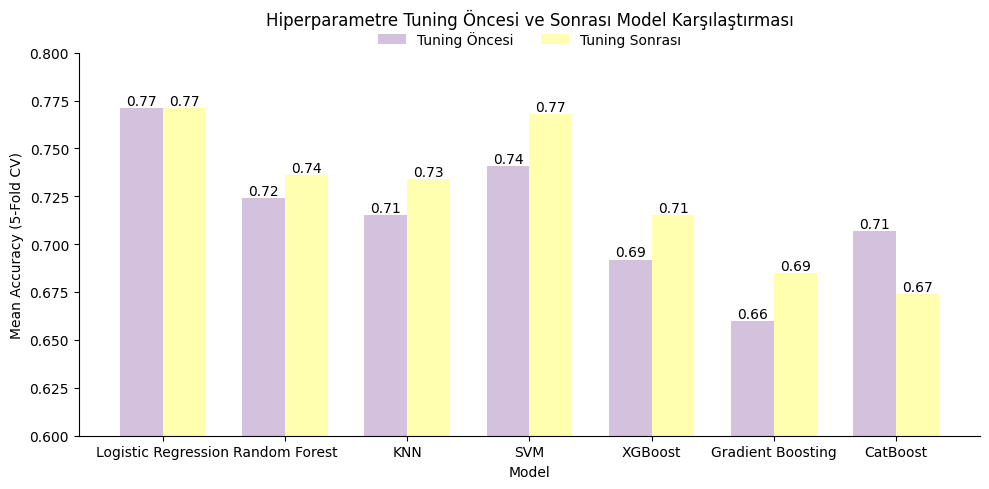

In [ ]:
original_scores = {
    "Logistic Regression": 0.771,
    "Random Forest": 0.724,
    "KNN": 0.715,
    "SVM": 0.741,
    "XGBoost": 0.692,
    "Gradient Boosting": 0.660,
    "CatBoost": 0.707
}


tuned_scores = {
    "Logistic Regression": 0.771,
    "Random Forest": 0.736,
    "KNN": 0.734,
    "SVM": 0.768,
    "XGBoost": 0.715,
    "Gradient Boosting": 0.685,
    "CatBoost": 0.674
}


models = list(original_scores.keys())
original = [original_scores[m] for m in models]
tuned = [tuned_scores[m] for m in models]
paired_colors = sns.color_palette("Paired", n_colors=12)

plt.figure(figsize=(10, 5))
bar_width = 0.35
index = range(len(models))

plt.bar(index, original, bar_width, label='Tuning √ñncesi', alpha=0.8, color=paired_colors[8])
plt.bar([i + bar_width for i in index], tuned, bar_width, label='Tuning Sonrasƒ±', alpha=0.8, color=paired_colors[10])

for i in index:
    plt.text(i, original[i], f'{original[i]:.2f}', ha='center', va='bottom', fontsize=10)
    plt.text(i + bar_width, tuned[i], f'{tuned[i]:.2f}', ha='center', va='bottom', fontsize=10)

plt.ylim(0.6, .8)
plt.xlabel('Model')
plt.ylabel('Mean Accuracy (5-Fold CV)')
plt.title('Hiperparametre Tuning √ñncesi ve Sonrasƒ± Model Kar≈üƒ±la≈ütƒ±rmasƒ±', y=1.05)
plt.xticks([i + bar_width / 2 for i in index], models)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.09), ncol=2, frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()




Hiperparametre tuning i≈ülemi, √ßoƒüu modelin doƒüruluk oranƒ±nda iyile≈üme saƒülamƒ±≈ütƒ±r.
Bu iyile≈ümeler, model performansƒ±nƒ±n yalnƒ±zca algoritma se√ßimine deƒüil, doƒüru parametre kombinasyonuna da baƒülƒ± olduƒüunu g√∂stermektedir.

* **SVM**, **XGBoost** ve **Gradient Boosting**, tuning sonrasƒ±nda en belirgin doƒüruluk artƒ±≈üƒ±nƒ± ya≈üamƒ±≈ütƒ±r. Bu durum, bu modellerin parametre hassasiyetinin y√ºksek olduƒüunu ortaya koyar.
* **KNN** ve **Random Forest**, tuning sonrasƒ± daha sƒ±nƒ±rlƒ± fakat anlamlƒ± kazanƒ±mlar elde etmi≈ütir.
* **Logistic Regression**, tuning √∂ncesi ve sonrasƒ± aynƒ± doƒüruluƒüu verdiƒüinden parametrelerden fazla etkilenmemi≈ütir. Yorumlanabilirliƒüin √∂nemli olduƒüu durumlar i√ßin halen g√º√ßl√º bir tercihtir.
* **CatBoost**‚Äôta tuning sonrasƒ± doƒürulukta k√º√ß√ºk bir d√º≈ü√º≈ü g√∂zlemlenmi≈ütir. Bu durum, varsayƒ±lan ayarlarƒ±nƒ±n zaten olduk√ßa optimize olabileceƒüini d√º≈ü√ºnd√ºrmektedir.

Genel olarak grafik, tuning i≈üleminin model ba≈üarƒ±mƒ±nƒ± artƒ±rmada √∂nemli bir rol oynadƒ±ƒüƒ±nƒ± ve her model i√ßin ayrƒ± ayrƒ± deƒüerlendirilmesi gerektiƒüini g√∂stermektedir.


Bu proje, medikal veri analizi ile yapay zeka modellerinin nasƒ±l birle≈üebileceƒüini g√∂steren u√ßtan uca bir √ßalƒ±≈ümaydƒ±.

Veri setini yalnƒ±zca sayƒ±sal olarak deƒüil, klinik baƒülamda da ele alarak eksik ve aykƒ±rƒ± verileri anlamlƒ± ≈üekilde y√∂nettim.
Modelleme s√ºrecinde ise yalnƒ±zca doƒüruluk oranlarƒ±na deƒüil, hasta ka√ßƒ±rma riskine yani False Negative deƒüerine √∂ncelik verdim.

Sonu√ßlara g√∂re, KNN modeli en d√º≈ü√ºk FN deƒüeriyle klinik riski en aza indirirken, Lojistik Regresyon stabil yapƒ±sƒ±yla g√ºvenilir bir karar destek aracƒ± oldu.

Bu analiz, erken te≈ühisin hayati √∂nem ta≈üƒ±dƒ±ƒüƒ± kalp hastalƒ±klarƒ± gibi alanlarda veri bilimi desteƒüinin ne kadar deƒüerli olabileceƒüini bir kez daha ortaya koyuyor.

